In [43]:
# Yos Ivan Sirait
# Tahap 2: Data Preprocessing - IMPROVED VERSION

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import joblib

# df = pd.read_excel("tes_bersih.xlsx")
df = pd.read_csv(
    "v.baru.csv", sep=";",engine="python", quotechar='"', encoding="utf-8"
)
df = df.applymap(
    lambda x: x.replace("\n", " ").replace("\r", " ")
    if isinstance(x, str)else x
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 22 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Timestamp                                                      2276 non-null   object 
 1   Nama Lengkap                                                   2274 non-null   object 
 2   Jenis Kelamin                                                  2276 non-null   object 
 3   Jenis Sekolah Menengah atas yang anda tempuh                   2275 non-null   object 
 4   Asal Sekolah                                                   2266 non-null   object 
 5   Tingkat Kelas                                                  2303 non-null   object 
 6   Gaya belajar yang biasanya digunakan                           2271 non-null   object 
 7   Teknik belajar yang biasanya digunakan                      

C:\Users\user\AppData\Local\Temp\ipykernel_6900\2190222950.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [44]:
print("Missing values awal:")
print(df.isnull().sum())

print("Jumlah nama duplikat:", df["Nama Lengkap"].duplicated().sum())

df = df.drop_duplicates(subset="Nama Lengkap", keep="first")

print("Duplikat setelah dibersihkan:", df["Nama Lengkap"].duplicated().sum())
df.info()


Missing values awal:
Timestamp                                                          27
Nama Lengkap                                                       29
Jenis Kelamin                                                      27
Jenis Sekolah Menengah atas yang anda tempuh                       28
Asal Sekolah                                                       37
Tingkat Kelas                                                       0
Gaya belajar yang biasanya digunakan                               32
Teknik belajar yang biasanya digunakan                             32
Apakah kamu belajar sendiri atau dengan bantuan orang lain?        28
Lokasi Belajar                                                     31
Jam Belajar                                                        29
Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari             28
Total Waktu untuk Belajar Mandiri /Hari                            28
Catatan singkat tentang Belajar                                  1315

In [45]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

In [46]:
numeric_cols = [
    "Mood Saat Belajar",
    "Pikiran atau Stres Akademik",
    "Jumlah prestasi di dalam sekolah *",
    "Jumlah prestasi di luar sekolah "
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df["Mood Saat Belajar"] = df["Mood Saat Belajar"].fillna(3).astype(int)
df["Pikiran atau Stres Akademik"] = df["Pikiran atau Stres Akademik"].fillna(3).astype(int)

df["Jumlah prestasi di dalam sekolah *"] = df["Jumlah prestasi di dalam sekolah *"].fillna(0).astype(int)
df["Jumlah prestasi di luar sekolah "] = df["Jumlah prestasi di luar sekolah "].fillna(0).astype(int)

In [47]:
df["Rata rata nilai Siswa(nilai tarakhir)"] = (
    df["Rata rata nilai Siswa(nilai tarakhir)"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .pipe(pd.to_numeric, errors="coerce")
)

df = df.dropna(subset=["Rata rata nilai Siswa(nilai tarakhir)"])


In [48]:
import unicodedata
import numpy as np

def normalize_text(x):
    if pd.isna(x):
        return np.nan
    x = unicodedata.normalize("NFKC", str(x).lower().strip())
    return x if x != "nan" else np.nan

for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].apply(normalize_text)


In [49]:
target_col = "Rata rata nilai Siswa(nilai tarakhir)"

print("Jumlah data sebelum filtering:", df.shape[0])

df = df[
    (df[target_col] >= 0) &
    (df[target_col] <= 100)
]

print("Jumlah data setelah filtering:", df.shape[0])


Jumlah data sebelum filtering: 1591
Jumlah data setelah filtering: 1588


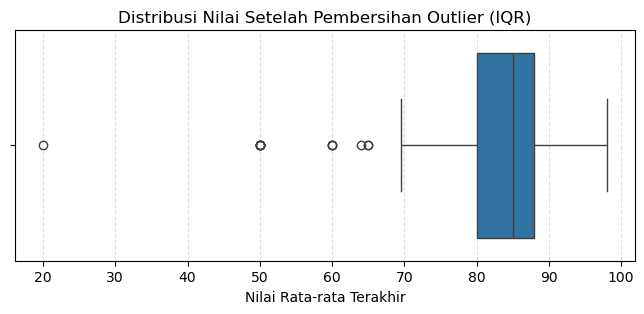

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
sns.boxplot(x=df["Rata rata nilai Siswa(nilai tarakhir)"])
plt.title("Distribusi Nilai Setelah Pembersihan Outlier (IQR)")
plt.xlabel("Nilai Rata-rata Terakhir")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.show()

In [51]:
# df.to_csv("tes_bersih.csv", index=False, encoding="utf-8-sig")

In [52]:
def map_gaya(x):
    if pd.isna(x): return np.nan
    if "visual" in x: return "visual"
    if "auditory" in x: return "auditory"
    if "kinestetik" in x: return "kinestetik"
    return "lainnya"

df["Gaya belajar yang biasanya digunakan"] = df["Gaya belajar yang biasanya digunakan"].apply(map_gaya)


def map_teknik(x):
    if pd.isna(x): return np.nan
    if "pomodoro" in x or "podomoro" in x: return "podomoro"
    if "active recall" in x: return "active_recall"
    if "feynman" in x: return "feynman"
    if "latihan soal" in x: return "latihan_soal"
    if "spaced" in x: return "spaced_repetition"
    return "lainnya"

df["Teknik belajar yang biasanya digunakan"] = df["Teknik belajar yang biasanya digunakan"].apply(map_teknik)


In [53]:
def map_lokasi(x):
    if pd.isna(x): return "lainnya"
    if any(k in x for k in ["rumah", "kamar", "kost", "meja"]): return "rumah"
    if any(k in x for k in ["sekolah", "kelas", "bengkel"]): return "sekolah"
    if "asrama" in x: return "asrama"
    if any(k in x for k in ["les", "bimbel"]): return "bimbel_les"
    if "perpustakaan" in x: return "perpustakaan"
    return "lainnya"

df["Lokasi Belajar"] = df["Lokasi Belajar"].apply(map_lokasi)


def map_asal_sekolah(x):
    if pd.isna(x):
        return "lainnya"
    x = str(x).lower().strip()
    if ("bintang timur" in x or "btb" in x) and "sma" in x:
        return "sma_sw_bintang_timur_balige"
    if "yapim" in x and "smk" in x:
        return "smk_yapim_balige"
    if "laguboti" in x and "smk" in x and "1" in x:
        return "smk_n_1_laguboti"
    if "arjuna" in x and "smk" in x:
        return "smk_arjuna_laguboti"
    if ("siantarnarumonda" in x or "siantar narumonda" in x):
        return "sman_1_narumonda"
    if "laguboti" in x and "sma" in x:
        return "sman_1_laguboti"
    if "2 balige" in x and "sma" in x:
        return "sman_2_balige"
    if "1 balige" in x and "sma" in x:
        return "sman_1_balige"
    if "2 balige" in x and "smk" in x:
        return "smkn_2_balige"
    if "3 balige" in x and "smk" in x:
        return "smkn_3_balige"
    if ("siborongborong" in x or "siborong-borong" in x) and "sma" in x:
        return "sman_2_siborongborong"
    if "uluan" in x and "sma" in x:
        return "sman_1_uluan"

    return "lainnya"


df["Asal Sekolah"] = df["Asal Sekolah"].apply(map_asal_sekolah)


In [54]:
mapping_waktu = {
    "< 15 menit": 1,
    "15 - 30 menit": 2,
    "30 - 60 menit": 3,
    "> 60 menit": 4
}

for col in [
    "Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari",
    "Total Waktu untuk Belajar Mandiri /Hari"
]:
    df[col] = df[col].map(mapping_waktu)

df["total_waktu_belajar"] = (
    df["Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari"] +
    df["Total Waktu untuk Belajar Mandiri /Hari"]
)

In [55]:
one_hot_cols = [
    "Gaya belajar yang biasanya digunakan",
    "Teknik belajar yang biasanya digunakan",
    "Jenis Kelamin",
    "Jam Belajar",
    "Jenis Sekolah Menengah atas yang anda tempuh",
    "Apakah kamu belajar sendiri atau dengan bantuan orang lain? ",
    "Lokasi Belajar",
    "Asal Sekolah",
    "Apakah Anda pernah meraih prestasi di dalam atau luar sekolah"
]

df = pd.get_dummies(df, columns=one_hot_cols, drop_first=False)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1588 entries, 0 to 2292
Data columns (total 54 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Timestamp                                                                         1588 non-null   object 
 1   Nama Lengkap                                                                      1588 non-null   object 
 2   Tingkat Kelas                                                                     1588 non-null   object 
 3   Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari                            1588 non-null   int64  
 4   Total Waktu untuk Belajar Mandiri /Hari                                           1588 non-null   int64  
 5   Catatan singkat tentang Belajar                                                   888 non-null    object 
 6   Mood 

In [56]:
df.head()

,Timestamp,Nama Lengkap,Tingkat Kelas,Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari,Total Waktu untuk Belajar Mandiri /Hari,Catatan singkat tentang Belajar,Mood Saat Belajar,Pikiran atau Stres Akademik,Rata rata nilai Siswa(nilai tarakhir),Jumlah prestasi di dalam sekolah *,...,Asal Sekolah_sman_1_uluan,Asal Sekolah_sman_2_balige,Asal Sekolah_sman_2_siborongborong,Asal Sekolah_smk_arjuna_laguboti,Asal Sekolah_smk_n_1_laguboti,Asal Sekolah_smk_yapim_balige,Asal Sekolah_smkn_2_balige,Asal Sekolah_smkn_3_balige,Apakah Anda pernah meraih prestasi di dalam atau luar sekolah_tidak,Apakah Anda pernah meraih prestasi di dalam atau luar sekolah_ya
0,12/04/2025 13:59,jonatan ambarita,xi,3,2,belajar membuat kita jadi hidup,4,4,88.00,0,...,False,False,False,False,False,False,False,False,True,False
1,12/05/2025 08:53,selsa angelicha manurung,xii,2,2,belajar membuat saya dapat memahami dalam hal ...,3,3,87.00,0,...,False,False,False,False,False,False,False,False,False,True
2,12/05/2025 08:58,aksirapi napitupulu,xii,2,3,fokus dan jangan ter distraksi,4,3,91.75,2,...,False,False,False,False,False,False,False,False,False,True
3,12/05/2025 09:00,yohana marpaung,xii,2,3,"belajar adalah proses memperoleh pengetahuan, ...",3,3,90.00,1,...,False,False,False,False,False,False,False,False,False,True
4,12/05/2025 09:02,margareth arta marpaung,xii,3,2,NaN,3,3,87.00,1,...,False,False,False,False,False,False,False,False,True,False


In [57]:
# df.to_csv("tes_bersih.csv", index=False, encoding="utf-8-sig")

In [58]:
# eda
numeric_cols = [
    "Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari",
    "Total Waktu untuk Belajar Mandiri /Hari",
    "Mood Saat Belajar",
    "Pikiran atau Stres Akademik",
    "Rata rata nilai Siswa(nilai tarakhir)",
    "Jumlah prestasi di dalam sekolah *",
    "Jumlah prestasi di luar sekolah ",
    "total_waktu_belajar"
]

df[numeric_cols].describe()


,Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari,Total Waktu untuk Belajar Mandiri /Hari,Mood Saat Belajar,Pikiran atau Stres Akademik,Rata rata nilai Siswa(nilai tarakhir),Jumlah prestasi di dalam sekolah *,Jumlah prestasi di luar sekolah,total_waktu_belajar
count,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000
mean,2.758186,2.512594,3.728589,3.350126,84.016178,0.540932,0.438287,5.270781
std,0.850199,0.894832,1.036213,1.129132,5.445960,0.883347,0.816864,1.490902
min,1.000000,1.000000,1.000000,1.000000,20.000000,0.000000,0.000000,2.000000
25%,2.000000,2.000000,3.000000,3.000000,80.000000,0.000000,0.000000,4.000000
50%,3.000000,2.000000,4.000000,3.000000,85.000000,0.000000,0.000000,5.000000
75%,3.000000,3.000000,5.000000,4.000000,88.000000,1.000000,1.000000,6.000000
max,4.000000,4.000000,5.000000,5.000000,98.000000,3.000000,3.000000,8.000000


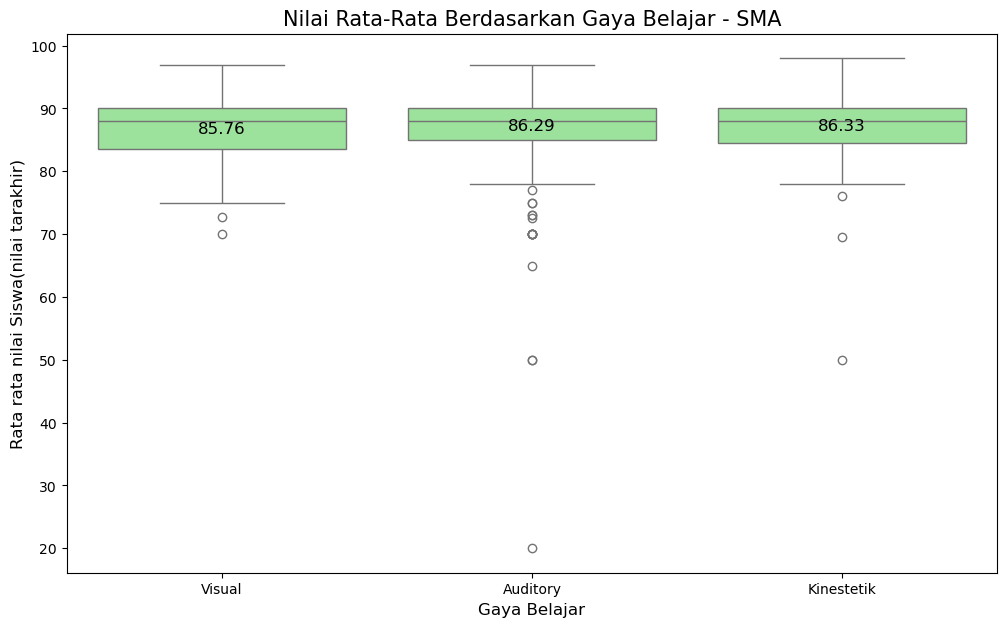

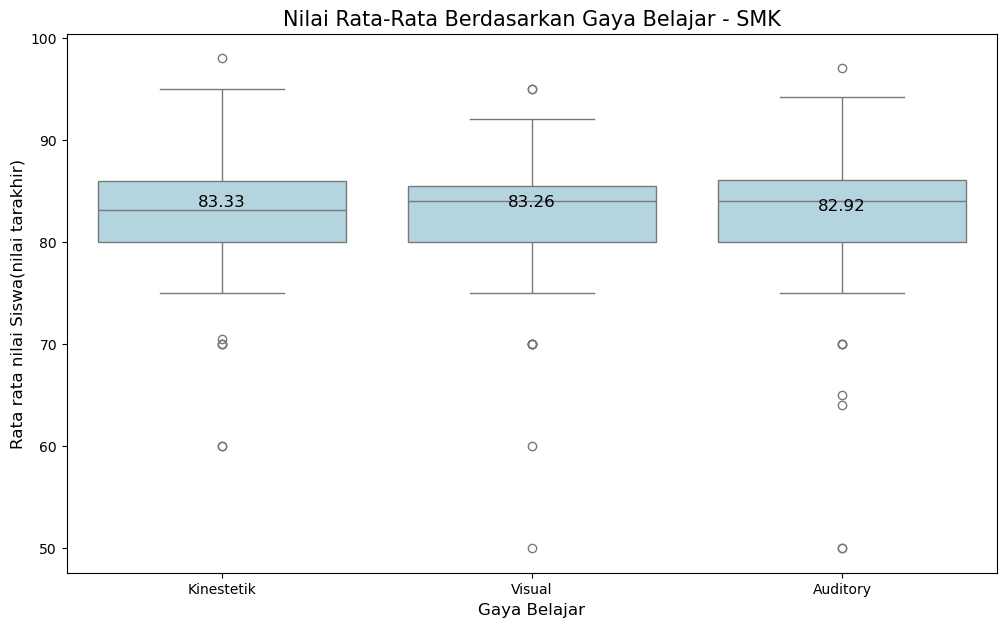


--- Rata-Rata Nilai per Gaya Belajar untuk SMA ---
Gaya_Belajar_Label
Auditory      85.757204
Kinestetik    86.285691
Visual        86.329391
Name: Rata rata nilai Siswa(nilai tarakhir), dtype: float64

--- Rata-Rata Nilai per Gaya Belajar untuk SMK ---
Gaya_Belajar_Label
Auditory      83.326509
Kinestetik    83.255028
Visual        82.917791
Name: Rata rata nilai Siswa(nilai tarakhir), dtype: float64


In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_gaya_belajar(row):
    if row['Gaya belajar yang biasanya digunakan_auditory'] == 1:
        return 'Auditory'
    elif row['Gaya belajar yang biasanya digunakan_visual'] == 1:
        return 'Visual'
    elif row['Gaya belajar yang biasanya digunakan_kinestetik'] == 1:
        return 'Kinestetik'
    else:
        return 'Tidak Diketahui'

df['Gaya_Belajar_Label'] = df.apply(get_gaya_belajar, axis=1)

df_filtered = df[df['Gaya_Belajar_Label'] != 'Tidak Diketahui']

df_sma = df_filtered[df_filtered['Jenis Sekolah Menengah atas yang anda tempuh_sma'] == 1]
df_smk = df_filtered[df_filtered['Jenis Sekolah Menengah atas yang anda tempuh_smk'] == 1]

plt.figure(figsize=(12, 7))
sns.boxplot(
    x='Gaya_Belajar_Label',
    y='Rata rata nilai Siswa(nilai tarakhir)',
    data=df_sma,
    color='lightgreen'  
)

avg_nilai_sma = df_sma.groupby('Gaya_Belajar_Label')['Rata rata nilai Siswa(nilai tarakhir)'].mean()
for i, label in enumerate(avg_nilai_sma):
    plt.text(i, label + 0.2, f'{label:.2f}', ha='center', fontsize=12, color='black')

plt.title('Nilai Rata-Rata Berdasarkan Gaya Belajar - SMA', fontsize=15)
plt.xlabel('Gaya Belajar', fontsize=12)
plt.ylabel('Rata rata nilai Siswa(nilai tarakhir)', fontsize=12)
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(
    x='Gaya_Belajar_Label',
    y='Rata rata nilai Siswa(nilai tarakhir)',
    data=df_smk,
    color='lightblue' 
)

avg_nilai_smk = df_smk.groupby('Gaya_Belajar_Label')['Rata rata nilai Siswa(nilai tarakhir)'].mean()
for i, label in enumerate(avg_nilai_smk):
    plt.text(i, label + 0.2, f'{label:.2f}', ha='center', fontsize=12, color='black')

plt.title('Nilai Rata-Rata Berdasarkan Gaya Belajar - SMK', fontsize=15)
plt.xlabel('Gaya Belajar', fontsize=12)
plt.ylabel('Rata rata nilai Siswa(nilai tarakhir)', fontsize=12)
plt.show()

print("\n--- Rata-Rata Nilai per Gaya Belajar untuk SMA ---")
print(avg_nilai_sma)

print("\n--- Rata-Rata Nilai per Gaya Belajar untuk SMK ---")
print(avg_nilai_smk)


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1588 entries, 0 to 2292
Data columns (total 55 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Timestamp                                                                         1588 non-null   object 
 1   Nama Lengkap                                                                      1588 non-null   object 
 2   Tingkat Kelas                                                                     1588 non-null   object 
 3   Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari                            1588 non-null   int64  
 4   Total Waktu untuk Belajar Mandiri /Hari                                           1588 non-null   int64  
 5   Catatan singkat tentang Belajar                                                   888 non-null    object 
 6   Mood 

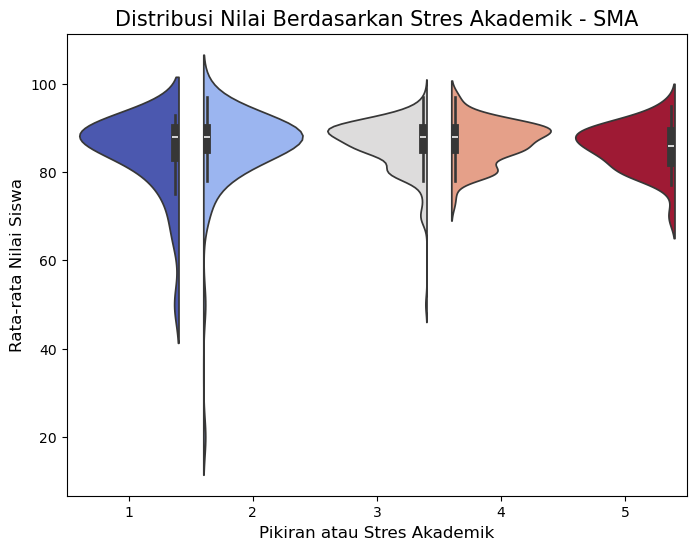


--- Rata-Rata Nilai per Tingkat Stres Akademik - SMA ---
Pikiran atau Stres Akademik
4    86.732308
3    86.238050
5    85.627778
2    85.502400
1    84.492353
Name: Rata rata nilai Siswa(nilai tarakhir), dtype: float64
Tingkat Stres 4: Rata-rata Nilai = 86.73
Tingkat Stres 3: Rata-rata Nilai = 86.24
Tingkat Stres 5: Rata-rata Nilai = 85.63
Tingkat Stres 2: Rata-rata Nilai = 85.50
Tingkat Stres 1: Rata-rata Nilai = 84.49


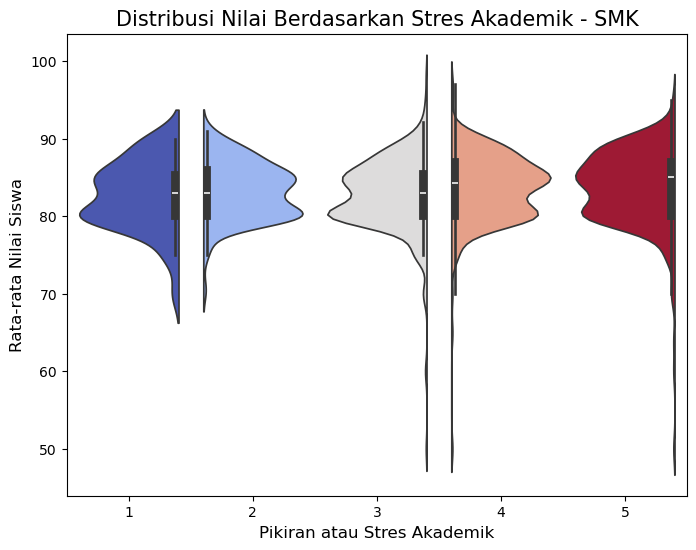


--- Rata-Rata Nilai per Tingkat Stres Akademik - SMK ---
Pikiran atau Stres Akademik
5    83.614491
4    83.607127
2    83.271008
3    82.791912
1    82.615385
Name: Rata rata nilai Siswa(nilai tarakhir), dtype: float64
Tingkat Stres 5: Rata-rata Nilai = 83.61
Tingkat Stres 4: Rata-rata Nilai = 83.61
Tingkat Stres 2: Rata-rata Nilai = 83.27
Tingkat Stres 3: Rata-rata Nilai = 82.79
Tingkat Stres 1: Rata-rata Nilai = 82.62


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

df_sma = df[df['Jenis Sekolah Menengah atas yang anda tempuh_sma'] == 1]
df_smk = df[df['Jenis Sekolah Menengah atas yang anda tempuh_smk'] == 1]

plt.figure(figsize=(8, 6))
sns.violinplot(
    x='Pikiran atau Stres Akademik',
    y='Rata rata nilai Siswa(nilai tarakhir)', 
    data=df_sma,
    hue='Pikiran atau Stres Akademik',  
    split=True,  
    palette='coolwarm',
    legend=False  
)
plt.title('Distribusi Nilai Berdasarkan Stres Akademik - SMA', fontsize=15)
plt.xlabel('Pikiran atau Stres Akademik', fontsize=12)
plt.ylabel('Rata-rata Nilai Siswa', fontsize=12)
plt.show()

avg_nilai_stres_sma = df_sma.groupby('Pikiran atau Stres Akademik')['Rata rata nilai Siswa(nilai tarakhir)'].mean().sort_values(ascending=False)
print("\n--- Rata-Rata Nilai per Tingkat Stres Akademik - SMA ---")
print(avg_nilai_stres_sma)

for level, nilai in avg_nilai_stres_sma.items():
    print(f"Tingkat Stres {level}: Rata-rata Nilai = {nilai:.2f}")

plt.figure(figsize=(8, 6))
sns.violinplot(
    x='Pikiran atau Stres Akademik',
    y='Rata rata nilai Siswa(nilai tarakhir)', 
    data=df_smk,
    hue='Pikiran atau Stres Akademik', 
    split=True,  
    palette='coolwarm',  
    legend=False  
)
plt.title('Distribusi Nilai Berdasarkan Stres Akademik - SMK', fontsize=15)
plt.xlabel('Pikiran atau Stres Akademik', fontsize=12)
plt.ylabel('Rata-rata Nilai Siswa', fontsize=12)
plt.show()

avg_nilai_stres_smk = df_smk.groupby('Pikiran atau Stres Akademik')['Rata rata nilai Siswa(nilai tarakhir)'].mean().sort_values(ascending=False)
print("\n--- Rata-Rata Nilai per Tingkat Stres Akademik - SMK ---")
print(avg_nilai_stres_smk)

for level, nilai in avg_nilai_stres_smk.items():
    print(f"Tingkat Stres {level}: Rata-rata Nilai = {nilai:.2f}")


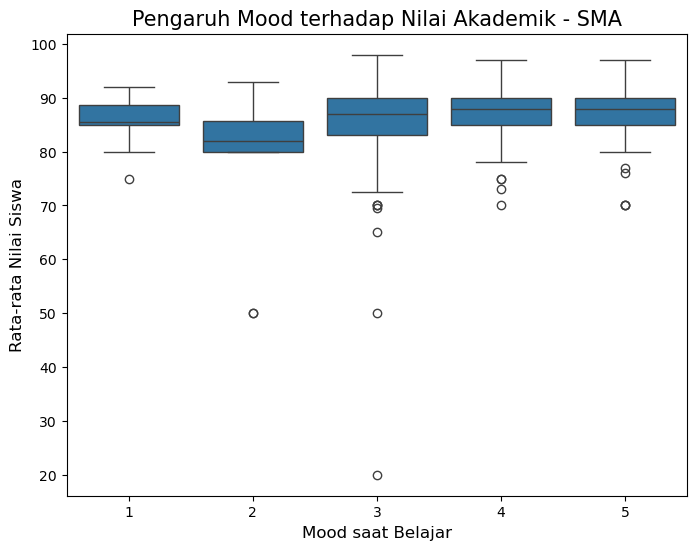


--- Rata-Rata Nilai per Mood - SMA ---
Mood Saat Belajar
4    86.911462
5    86.809036
3    85.415858
1    85.400000
2    79.968750
Name: Rata rata nilai Siswa(nilai tarakhir), dtype: float64
Mood 4: Rata-rata Nilai = 86.91
Mood 5: Rata-rata Nilai = 86.81
Mood 3: Rata-rata Nilai = 85.42
Mood 1: Rata-rata Nilai = 85.40
Mood 2: Rata-rata Nilai = 79.97


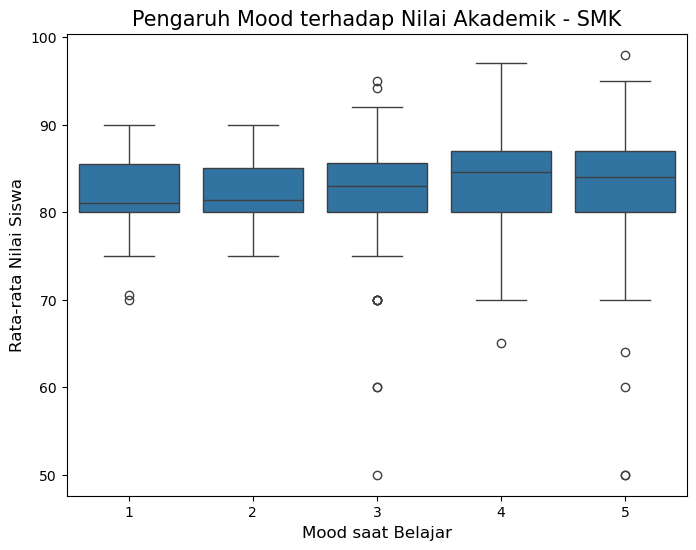


--- Rata-Rata Nilai per Mood - SMK ---
Mood Saat Belajar
4    83.763206
5    83.480439
3    82.730669
2    82.263571
1    82.160536
Name: Rata rata nilai Siswa(nilai tarakhir), dtype: float64
Mood 4: Rata-rata Nilai = 83.76
Mood 5: Rata-rata Nilai = 83.48
Mood 3: Rata-rata Nilai = 82.73
Mood 2: Rata-rata Nilai = 82.26
Mood 1: Rata-rata Nilai = 82.16


In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

df_sma = df[df['Jenis Sekolah Menengah atas yang anda tempuh_sma'] == 1]
df_smk = df[df['Jenis Sekolah Menengah atas yang anda tempuh_smk'] == 1]

plt.figure(figsize=(8, 6))
sns.boxplot(
    x='Mood Saat Belajar',  
    y='Rata rata nilai Siswa(nilai tarakhir)',  
    data=df_sma
)

plt.title('Pengaruh Mood terhadap Nilai Akademik - SMA', fontsize=15)
plt.xlabel('Mood saat Belajar', fontsize=12)
plt.ylabel('Rata-rata Nilai Siswa', fontsize=12)

plt.show()

avg_nilai_mood_sma = df_sma.groupby('Mood Saat Belajar')['Rata rata nilai Siswa(nilai tarakhir)'].mean().sort_values(ascending=False)
print("\n--- Rata-Rata Nilai per Mood - SMA ---")
print(avg_nilai_mood_sma)

for mood, nilai in avg_nilai_mood_sma.items():
    print(f"Mood {mood}: Rata-rata Nilai = {nilai:.2f}")

plt.figure(figsize=(8, 6))
sns.boxplot(
    x='Mood Saat Belajar',  
    y='Rata rata nilai Siswa(nilai tarakhir)', 
    data=df_smk
)

plt.title('Pengaruh Mood terhadap Nilai Akademik - SMK', fontsize=15)
plt.xlabel('Mood saat Belajar', fontsize=12)
plt.ylabel('Rata-rata Nilai Siswa', fontsize=12)

plt.show()

avg_nilai_mood_smk = df_smk.groupby('Mood Saat Belajar')['Rata rata nilai Siswa(nilai tarakhir)'].mean().sort_values(ascending=False)
print("\n--- Rata-Rata Nilai per Mood - SMK ---")
print(avg_nilai_mood_smk)

for mood, nilai in avg_nilai_mood_smk.items():
    print(f"Mood {mood}: Rata-rata Nilai = {nilai:.2f}")


Jumlah SMA: 449
Jumlah SMK: 1138


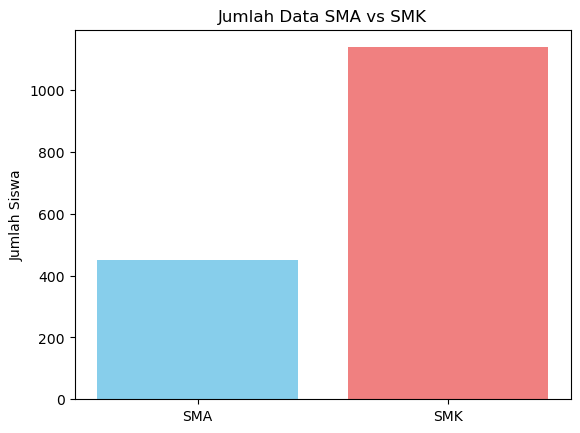

In [63]:
import matplotlib.pyplot as plt

df_sma = df[df['Jenis Sekolah Menengah atas yang anda tempuh_sma'] == 1]
df_smk = df[df['Jenis Sekolah Menengah atas yang anda tempuh_smk'] == 1]

print("Jumlah SMA:", len(df_sma))
print("Jumlah SMK:", len(df_smk))

counts = [
    len(df_sma),
    len(df_smk)
]

plt.bar(['SMA', 'SMK'], counts, color=['skyblue', 'lightcoral'])

plt.ylabel('Jumlah Siswa')
plt.title('Jumlah Data SMA vs SMK')

plt.show()


               SMA          SMK
mean     86.048530    83.213445
median   88.000000    83.970000
std       6.690865     4.634698
count   449.000000  1138.000000


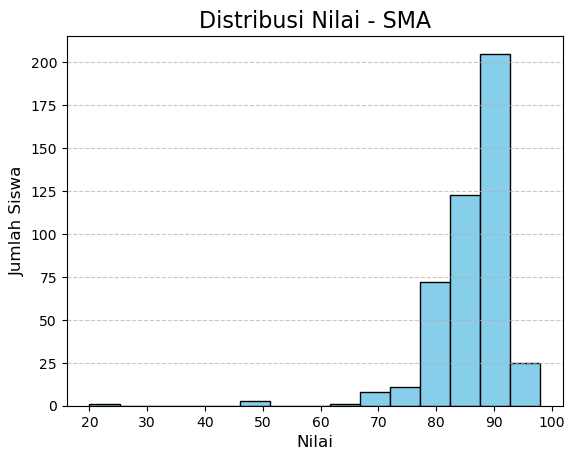

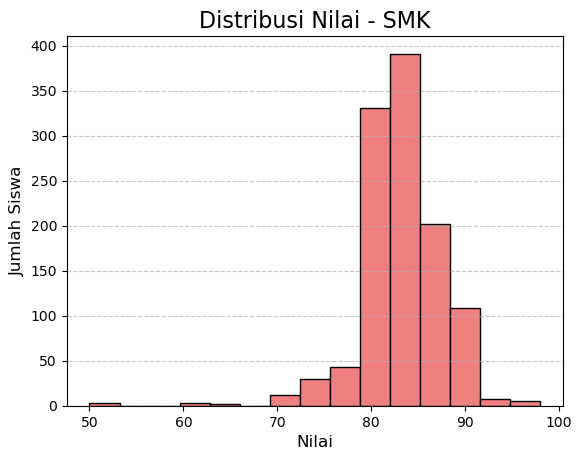

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

df_stats = pd.DataFrame({
    'SMA': df_sma['Rata rata nilai Siswa(nilai tarakhir)'].agg(['mean', 'median', 'std', 'count']),
    'SMK': df_smk['Rata rata nilai Siswa(nilai tarakhir)'].agg(['mean', 'median', 'std', 'count'])
})

print(df_stats)

plt.hist(df_sma['Rata rata nilai Siswa(nilai tarakhir)'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribusi Nilai - SMA', fontsize=16)
plt.xlabel('Nilai', fontsize=12)
plt.ylabel('Jumlah Siswa', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.hist(df_smk['Rata rata nilai Siswa(nilai tarakhir)'], bins=15, color='lightcoral', edgecolor='black')
plt.title('Distribusi Nilai - SMK', fontsize=16)
plt.xlabel('Nilai', fontsize=12)
plt.ylabel('Jumlah Siswa', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


SMA:
  Rata-rata nilai = 86.05
  Persentase di atas rata-rata = 56.6%

SMK:
  Rata-rata nilai = 83.21
  Persentase di atas rata-rata = 51.5%



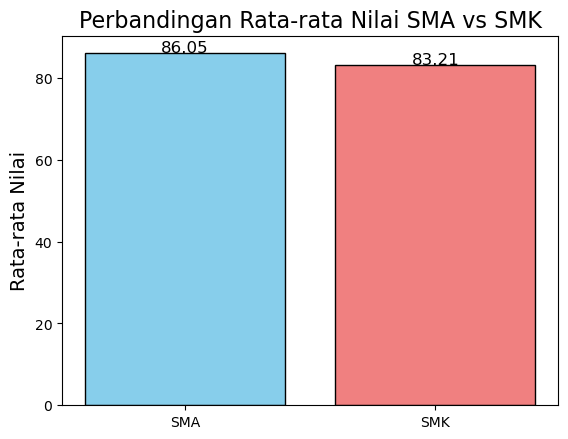

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

for nama, data in [('SMA', df_sma), ('SMK', df_smk)]:
    mean_nilai = data['Rata rata nilai Siswa(nilai tarakhir)'].mean()
    persen = (data['Rata rata nilai Siswa(nilai tarakhir)'] > mean_nilai).mean() * 100
    
    print(f"{nama}:")
    print(f"  Rata-rata nilai = {mean_nilai:.2f}")
    print(f"  Persentase di atas rata-rata = {persen:.1f}%\n")

mean_values = [
    df_sma['Rata rata nilai Siswa(nilai tarakhir)'].mean(),
    df_smk['Rata rata nilai Siswa(nilai tarakhir)'].mean()
]

plt.bar(['SMA', 'SMK'], mean_values, color=['skyblue', 'lightcoral'], edgecolor='black')

for i, value in enumerate(mean_values):
    plt.text(i, value + 0.2, f'{value:.2f}', ha='center', fontsize=12)

plt.ylabel('Rata-rata Nilai', fontsize=14)
plt.title('Perbandingan Rata-rata Nilai SMA vs SMK', fontsize=16)

plt.show()


SMA: r=0.382, p-value=0.0000
SMK: r=0.327, p-value=0.0000


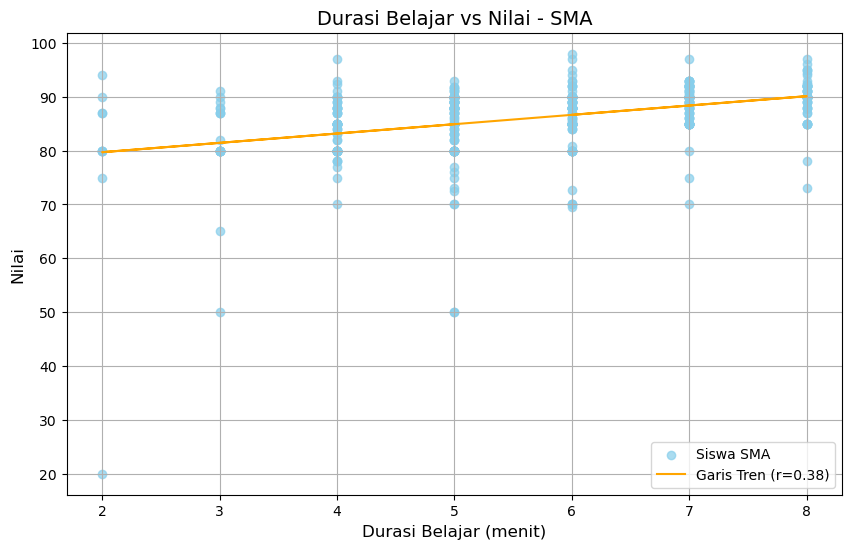

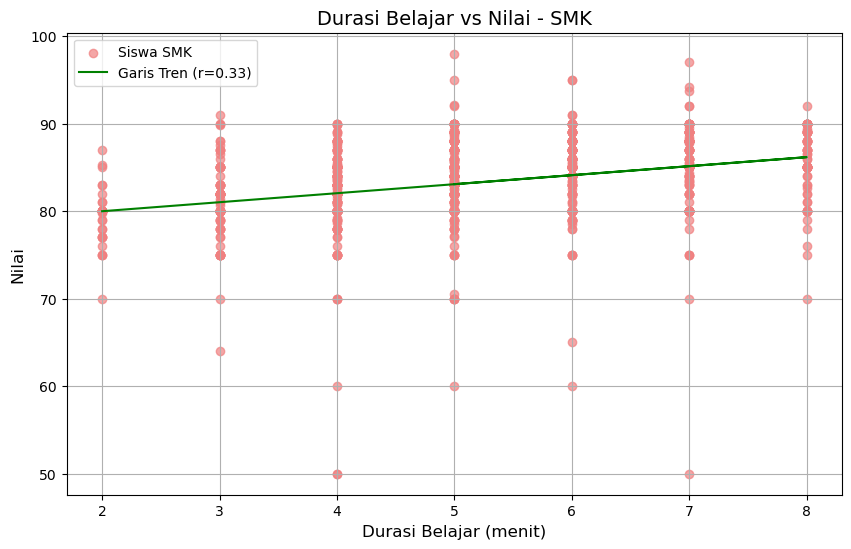

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import stats

cols = ['total_waktu_belajar', 'Rata rata nilai Siswa(nilai tarakhir)']

for nama, data in [('SMA', df_sma), ('SMK', df_smk)]:
    data_clean = (
        data[cols]
        .apply(pd.to_numeric, errors='coerce')
        .dropna()
    )

    if len(data_clean) < 3:
        print(f"{nama}: data terlalu sedikit")
        continue

    if data_clean[cols[0]].var() == 0 or data_clean[cols[1]].var() == 0:
        print(f"{nama}: variansi nol → korelasi tidak bisa dihitung")
        continue

    r, p = pearsonr(data_clean[cols[0]], data_clean[cols[1]])
    print(f"{nama}: r={r:.3f}, p-value={p:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(
    df_sma['total_waktu_belajar'],
    df_sma['Rata rata nilai Siswa(nilai tarakhir)'],
    color='skyblue', alpha=0.7, label='Siswa SMA'
)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_sma['total_waktu_belajar'], df_sma['Rata rata nilai Siswa(nilai tarakhir)'])
plt.plot(df_sma['total_waktu_belajar'], slope * df_sma['total_waktu_belajar'] + intercept, color='orange', label=f'Garis Tren (r={r_value:.2f})')

plt.xlabel('Durasi Belajar (menit)', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.title('Durasi Belajar vs Nilai - SMA', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    df_smk['total_waktu_belajar'],
    df_smk['Rata rata nilai Siswa(nilai tarakhir)'],
    color='lightcoral', alpha=0.7, label='Siswa SMK'
)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_smk['total_waktu_belajar'], df_smk['Rata rata nilai Siswa(nilai tarakhir)'])
plt.plot(df_smk['total_waktu_belajar'], slope * df_smk['total_waktu_belajar'] + intercept, color='green', label=f'Garis Tren (r={r_value:.2f})')

plt.xlabel('Durasi Belajar (menit)', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.title('Durasi Belajar vs Nilai - SMK', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [67]:
for nama, data in [('SMA', df_sma), ('SMK', df_smk)]:
    mean_nilai = data['Rata rata nilai Siswa(nilai tarakhir)'].mean()
    good = data[data['Rata rata nilai Siswa(nilai tarakhir)'] > mean_nilai]
    
    print(f"\n{nama}")
    print(good['total_waktu_belajar'].describe())



SMA
count    254.000000
mean       6.059055
std        1.452970
min        2.000000
25%        5.000000
50%        6.000000
75%        7.000000
max        8.000000
Name: total_waktu_belajar, dtype: float64

SMK
count    586.000000
mean       5.636519
std        1.338183
min        2.000000
25%        5.000000
50%        6.000000
75%        7.000000
max        8.000000
Name: total_waktu_belajar, dtype: float64


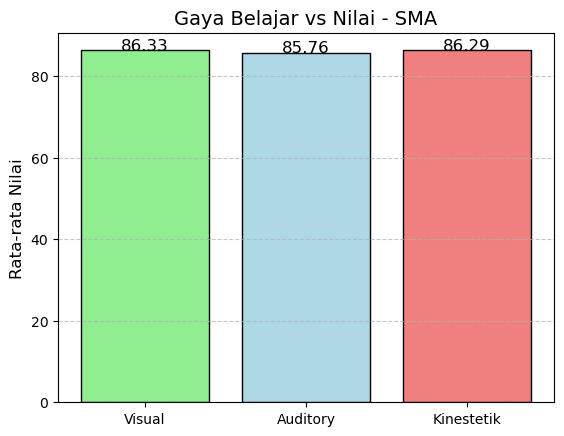

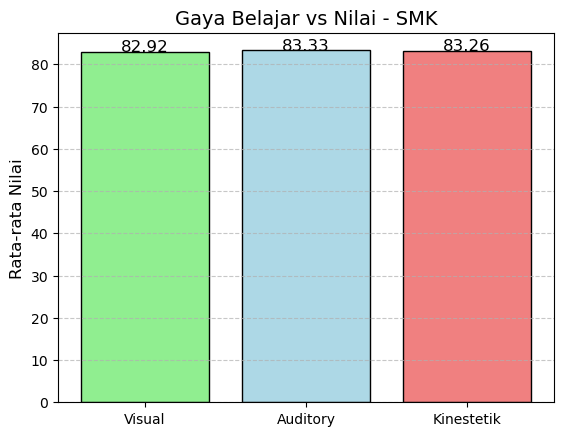

In [68]:
import matplotlib.pyplot as plt

gaya_cols = {
    'Visual': 'Gaya belajar yang biasanya digunakan_visual',
    'Auditory': 'Gaya belajar yang biasanya digunakan_auditory',
    'Kinestetik': 'Gaya belajar yang biasanya digunakan_kinestetik'
}

def plot_gaya(data, title):
    nilai = []
    label = []

    for k, col in gaya_cols.items():
        nilai.append(data.loc[data[col] == 1, 'Rata rata nilai Siswa(nilai tarakhir)'].mean())
        label.append(k)

    plt.bar(label, nilai, color=['lightgreen', 'lightblue', 'lightcoral'], edgecolor='black')

    for i, v in enumerate(nilai):
        plt.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=12)

    plt.ylabel('Rata-rata Nilai', fontsize=12)
    plt.title(title, fontsize=14)

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.show()

plot_gaya(df_sma, 'Gaya Belajar vs Nilai - SMA')
plot_gaya(df_smk, 'Gaya Belajar vs Nilai - SMK')


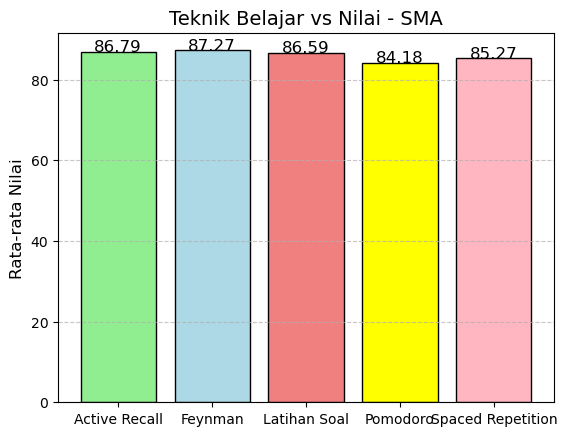

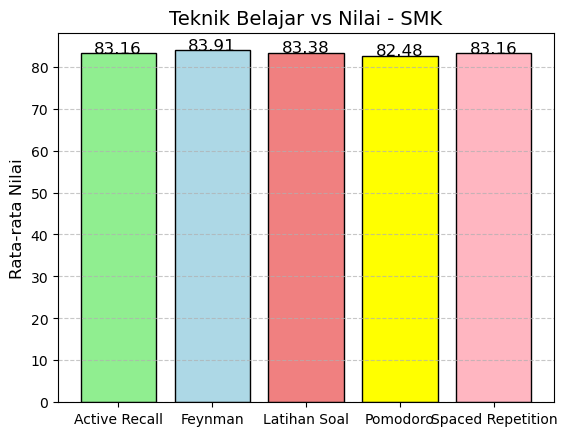

In [69]:
import matplotlib.pyplot as plt

teknik_cols = {
    'Active Recall': 'Teknik belajar yang biasanya digunakan_active_recall',
    'Feynman': 'Teknik belajar yang biasanya digunakan_feynman',
    'Latihan Soal': 'Teknik belajar yang biasanya digunakan_latihan_soal',
    'Pomodoro': 'Teknik belajar yang biasanya digunakan_podomoro',
    'Spaced Repetition': 'Teknik belajar yang biasanya digunakan_spaced_repetition'
}

def plot_teknik(data, title):
    nilai = []
    label = []

    for k, col in teknik_cols.items():
        nilai.append(data.loc[data[col] == 1, 'Rata rata nilai Siswa(nilai tarakhir)'].mean())
        label.append(k)

    plt.bar(label, nilai, color=['lightgreen', 'lightblue', 'lightcoral', 'yellow', 'lightpink'], edgecolor='black')

    for i, v in enumerate(nilai):
        plt.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=12)

    plt.ylabel('Rata-rata Nilai', fontsize=12)
    plt.title(title, fontsize=14)

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.show()

plot_teknik(df_sma, 'Teknik Belajar vs Nilai - SMA')
plot_teknik(df_smk, 'Teknik Belajar vs Nilai - SMK')


In [70]:
from scipy.stats import spearmanr

for nama, data in [('SMA', df_sma), ('SMK', df_smk)]:
    rho, p = spearmanr(
        data['Mood Saat Belajar'],
        data['Rata rata nilai Siswa(nilai tarakhir)']
    )
    print(f"{nama}: rho = {rho:.3f}, p-value = {p:.4f}")


SMA: rho = 0.128, p-value = 0.0064
SMK: rho = 0.107, p-value = 0.0003


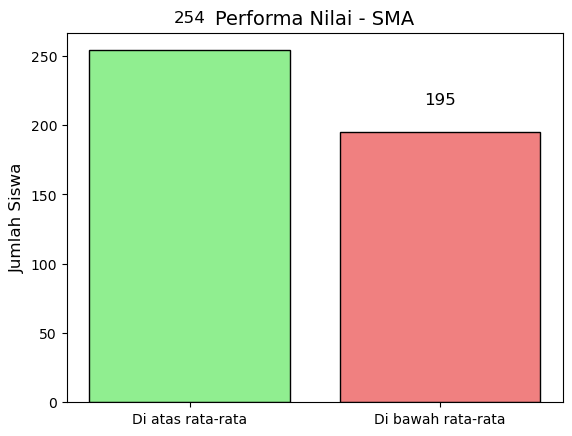

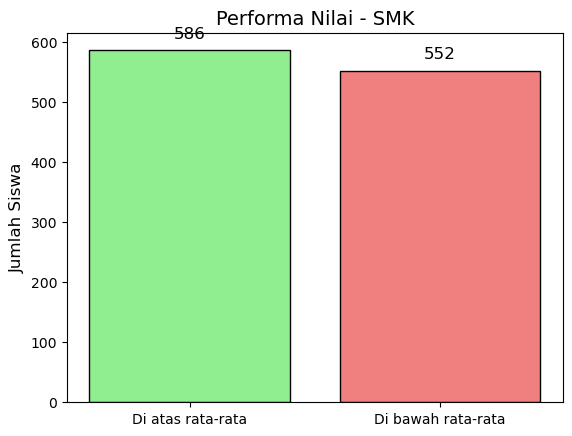

In [71]:
import matplotlib.pyplot as plt

labels = ['Di atas rata-rata', 'Di bawah rata-rata']

for nama, data in [('SMA', df_sma), ('SMK', df_smk)]:
    mean_nilai = data['Rata rata nilai Siswa(nilai tarakhir)'].mean()
    counts = [
        (data['Rata rata nilai Siswa(nilai tarakhir)'] > mean_nilai).sum(),
        (data['Rata rata nilai Siswa(nilai tarakhir)'] <= mean_nilai).sum()
    ]

    plt.bar(labels, counts, color=['lightgreen', 'lightcoral'], edgecolor='black')

    for i, count in enumerate(counts):
        plt.text(i, count + 20, str(count), ha='center', fontsize=12)

    plt.title(f'Performa Nilai - {nama}', fontsize=14)
    plt.ylabel('Jumlah Siswa', fontsize=12)

    plt.show()


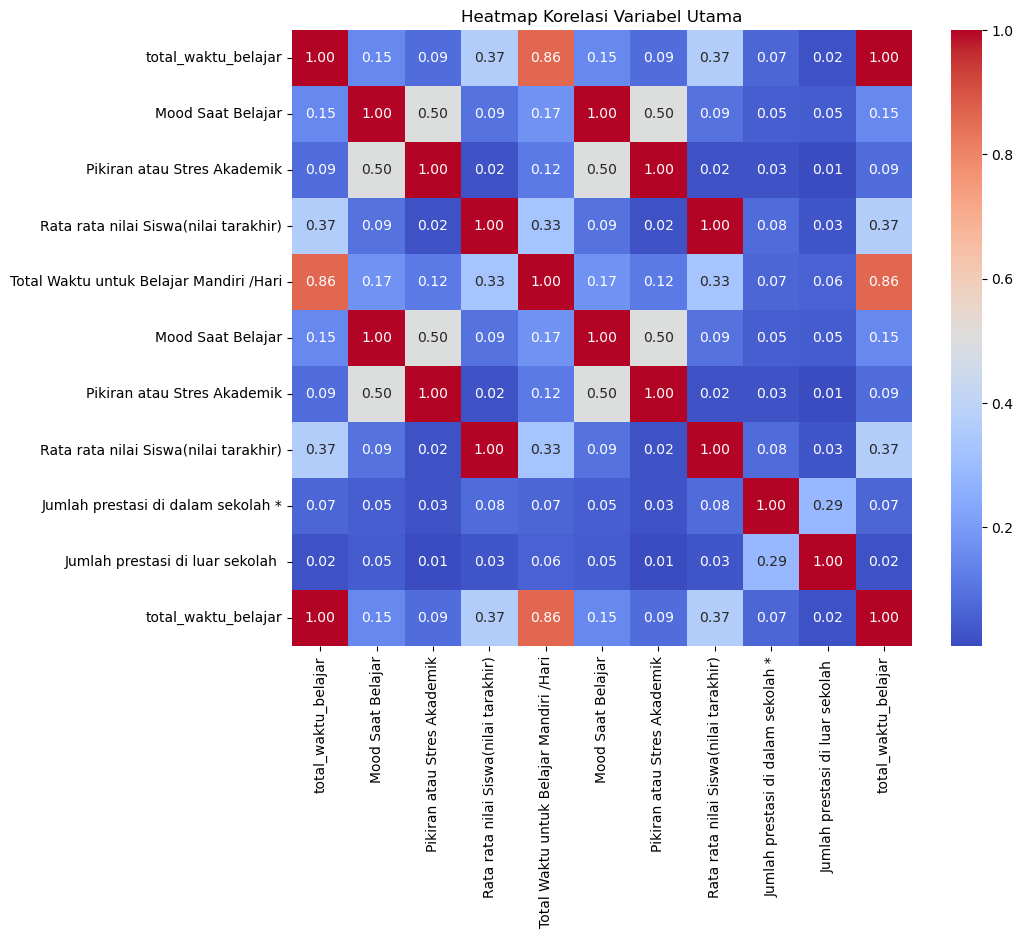

In [72]:
corr_cols = [
    "total_waktu_belajar",
    "Mood Saat Belajar",
    "Pikiran atau Stres Akademik",
    "Rata rata nilai Siswa(nilai tarakhir)",
    # "punya_prestasi",    "Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari",
    "Total Waktu untuk Belajar Mandiri /Hari",
    "Mood Saat Belajar",
    "Pikiran atau Stres Akademik",
    "Rata rata nilai Siswa(nilai tarakhir)",
    "Jumlah prestasi di dalam sekolah *",
    "Jumlah prestasi di luar sekolah ",
    "total_waktu_belajar"
]

plt.figure(figsize=(10,8))
sns.heatmap(
    df[corr_cols].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Heatmap Korelasi Variabel Utama")
plt.show()

In [73]:
# ==========================================================================
# #MOOODELLL   
# ==========================================================================

In [74]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

nilai_col = 'Rata rata nilai Siswa(nilai tarakhir)'

df['jenis_sekolah'] = np.where(
    df['Jenis Sekolah Menengah atas yang anda tempuh_sma'] == 1,
    'SMA',
    'SMK'
)

df['jenis_sekolah'].value_counts()
df['kelas_belajar_optimal'] = 0

for sekolah in ['SMA', 'SMK']:
    median_nilai = df.loc[
        df['jenis_sekolah'] == sekolah,
        nilai_col
    ].median()
    
    df.loc[
        (df['jenis_sekolah'] == sekolah) &
        (df[nilai_col] >= median_nilai),
        'kelas_belajar_optimal'
    ] = 1
df.groupby('jenis_sekolah')['kelas_belajar_optimal'].mean()


jenis_sekolah
SMA    0.512249
SMK    0.500439
Name: kelas_belajar_optimal, dtype: float64

In [75]:
# =======================================
# Random Forest#
# =======================================

In [76]:

print("\n[3] PREPARE FEATURES")
print("-"*70)

fitur_cols = [
    'Jenis Sekolah Menengah atas yang anda tempuh_sma',
    'Jenis Sekolah Menengah atas yang anda tempuh_smk',
    'total_waktu_belajar',
    'Mood Saat Belajar',
    'Pikiran atau Stres Akademik',
    'Gaya belajar yang biasanya digunakan_auditory',
    'Gaya belajar yang biasanya digunakan_visual',
    'Gaya belajar yang biasanya digunakan_kinestetik',
    'Teknik belajar yang biasanya digunakan_active_recall',
    'Teknik belajar yang biasanya digunakan_feynman',
    'Teknik belajar yang biasanya digunakan_podomoro',
    'Teknik belajar yang biasanya digunakan_spaced_repetition',
    'Teknik belajar yang biasanya digunakan_latihan_soal'
]

X = df[fitur_cols]
y = df['kelas_belajar_optimal']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {len(fitur_cols)}")


[3] PREPARE FEATURES
----------------------------------------------------------------------
Features shape: (1588, 13)
Target shape: (1588,)

Features used: 13


In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.550314465408805
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       158
           1       0.56      0.53      0.54       160

    accuracy                           0.55       318
   macro avg       0.55      0.55      0.55       318
weighted avg       0.55      0.55      0.55       318



In [78]:
# ============================================================================
# 5. BASELINE MODEL
# ============================================================================
print("\n[5] BASELINE MODEL")
print("-"*70)

rf_baseline = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"\nBaseline Accuracy: {baseline_accuracy:.4f}")
print("\nBaseline Classification Report:")
print(classification_report(y_test, y_pred_baseline))


[5] BASELINE MODEL
----------------------------------------------------------------------

Baseline Accuracy: 0.5503

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       158
           1       0.56      0.53      0.54       160

    accuracy                           0.55       318
   macro avg       0.55      0.55      0.55       318
weighted avg       0.55      0.55      0.55       318



In [34]:
# ============================================================================
# 6. HYPERPARAMETER TUNING
# ============================================================================
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

print("\n[6] HYPERPARAMETER TUNING (GridSearchCV)")
print("-"*70)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

print("Searching best parameters...")
print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("\nBest parameters found:")
for param, value in rf_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV F1-score: {rf_grid.best_score_:.4f}")



[6] HYPERPARAMETER TUNING (GridSearchCV)
----------------------------------------------------------------------
Searching best parameters...
Total combinations: 432
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best parameters found:
  class_weight: balanced_subsample
  max_depth: 20
  max_features: sqrt
  min_samples_leaf: 4
  min_samples_split: 2
  n_estimators: 300

Best CV F1-score: 0.6378


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, f1_score
)

# ============================================================================
# 7. BEST MODEL EVALUATION
# ============================================================================
print("\n[7] BEST MODEL EVALUATION")
print("-"*70)

best_rf = rf_grid.best_estimator_

# Predictions
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nBest Model Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1-score: {f1:.4f}")
print(f"  ROC-AUC: {roc_auc:.4f}")

print(f"\nImprovement over baseline:")
print(f"  Accuracy: {(accuracy - baseline_accuracy):.4f} ({((accuracy/baseline_accuracy - 1) * 100):.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Optimal', 'Optimal']))

# Cross-validation
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


[7] BEST MODEL EVALUATION
----------------------------------------------------------------------

Best Model Performance:
  Accuracy: 0.6258
  F1-score: 0.6383
  ROC-AUC: 0.6654

Improvement over baseline:
  Accuracy: 0.0755 (13.71%)

Classification Report:
              precision    recall  f1-score   support

 Not Optimal       0.63      0.59      0.61       158
     Optimal       0.62      0.66      0.64       160

    accuracy                           0.63       318
   macro avg       0.63      0.63      0.63       318
weighted avg       0.63      0.63      0.63       318


5-Fold Cross-Validation Accuracy: 0.6095 (+/- 0.0565)


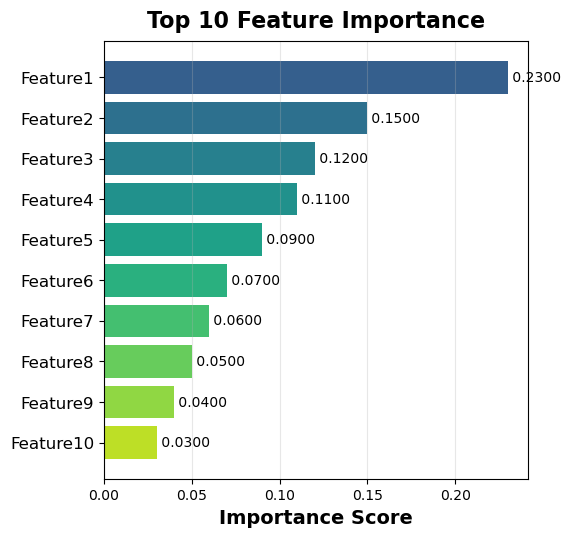

In [81]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(15, 10))
top_n = 10
top_features = importance_df.head(top_n)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
ax1 = plt.subplot(2, 3, 1)
bars = ax1.barh(range(len(top_features)), top_features['Importance'], color=colors)


ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels([f.replace('_', ' ').title()[:30] for f in top_features['Feature']], fontsize=12)
ax1.set_xlabel('Importance Score', fontsize=14, fontweight='bold')
ax1.set_title('Top 10 Feature Importance', fontsize=16, fontweight='bold', pad=10)
ax1.invert_yaxis()

ax1.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax1.text(row['Importance'], i, f" {row['Importance']:.4f}", va='center', fontsize=10)

# Menampilkan plot
plt.tight_layout()  # Untuk memastikan layout tidak tumpang tindih
plt.show()


Saved: rf_model_evaluation.png


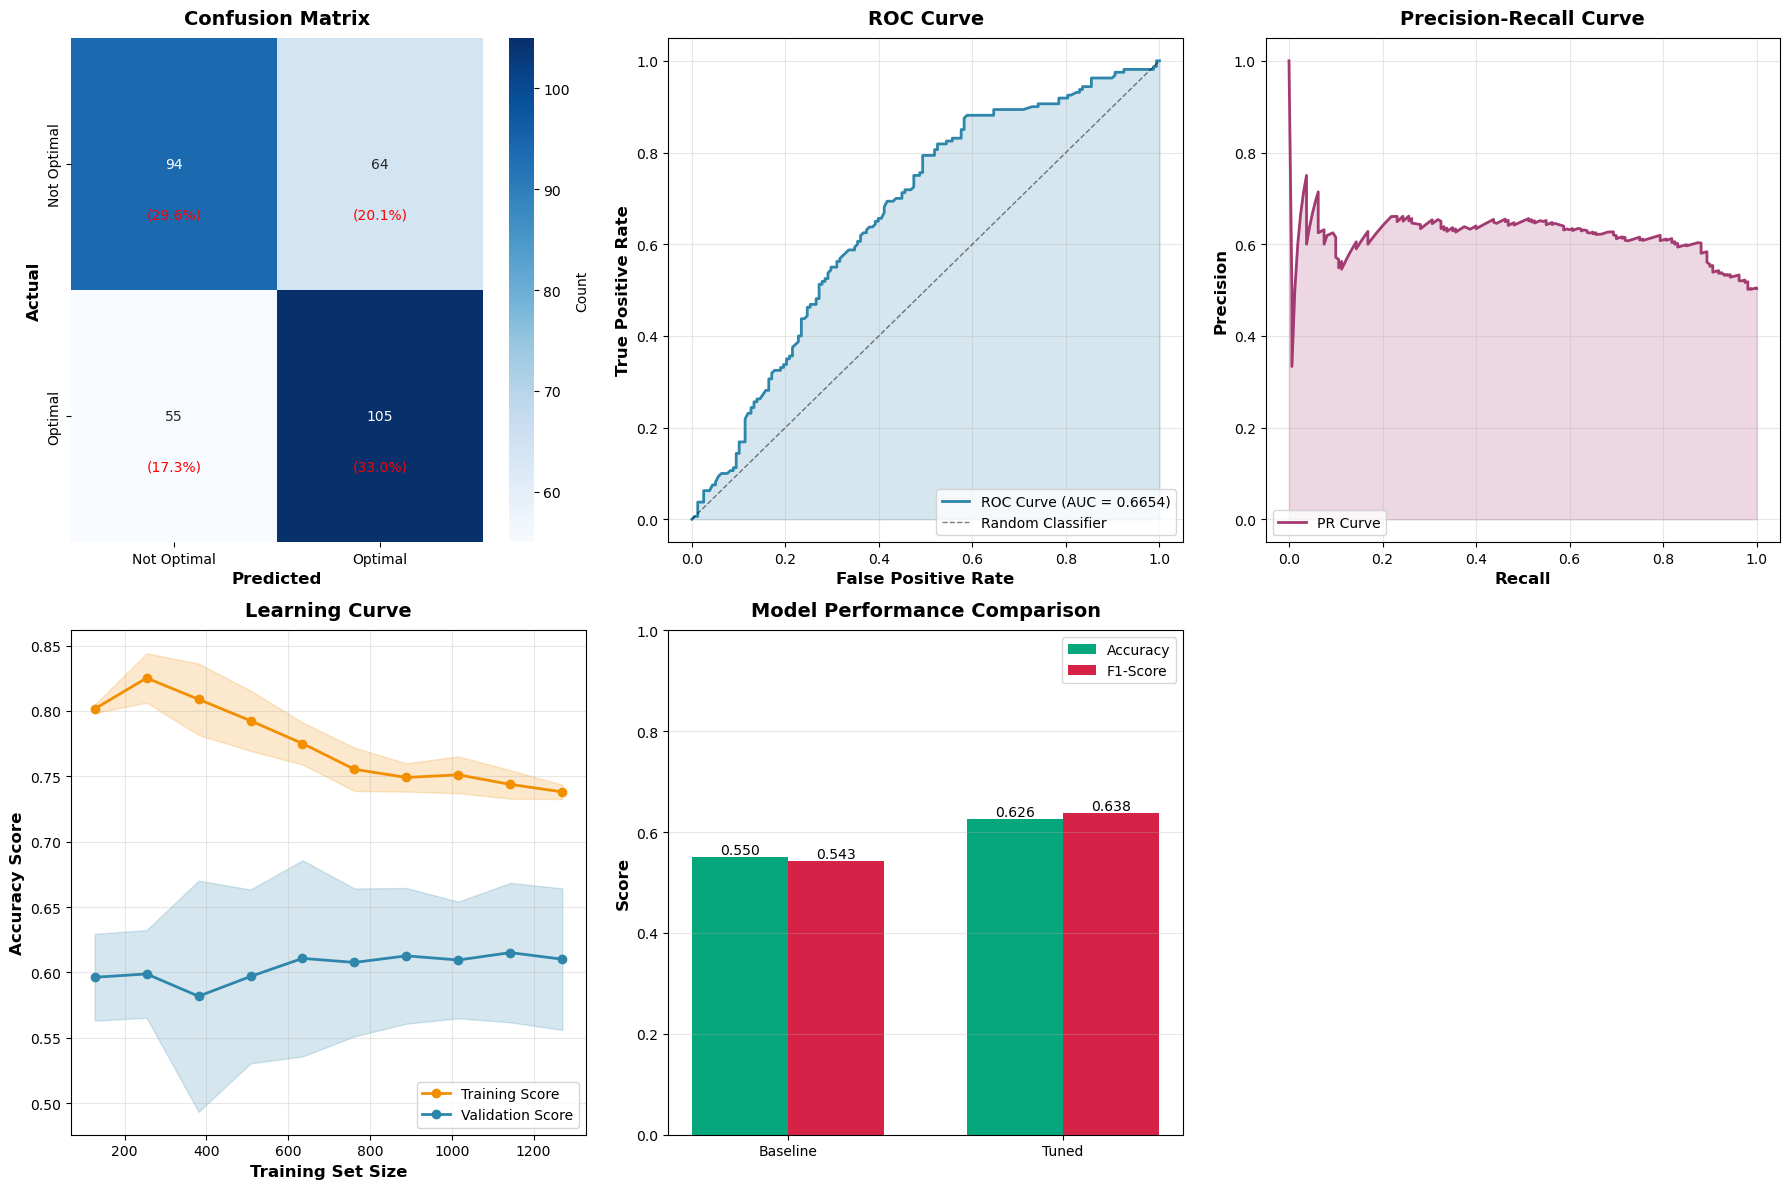


[10] ANALYSIS BY SCHOOL TYPE
----------------------------------------------------------------------


IndexError: positional indexers are out-of-bounds

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import learning_curve
import joblib

plt.figure(figsize=(18, 12))

ax2 = plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Optimal', 'Optimal'],
            yticklabels=['Not Optimal', 'Optimal'],
            ax=ax2, cbar_kws={'label': 'Count'})
ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=10)

for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        ax2.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                 ha='center', va='center', fontsize=10, color='red')

ax3 = plt.subplot(2, 3, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ax3.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='#2E86AB')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier', alpha=0.5)
ax3.fill_between(fpr, tpr, alpha=0.2, color='#2E86AB')
ax3.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax3.set_title('ROC Curve', fontsize=14, fontweight='bold', pad=10)
ax3.legend(loc='lower right', fontsize=10)
ax3.grid(alpha=0.3)

ax4 = plt.subplot(2, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax4.plot(recall, precision, linewidth=2, color='#A23B72', label='PR Curve')
ax4.fill_between(recall, precision, alpha=0.2, color='#A23B72')
ax4.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax4.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax4.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=10)
ax4.legend(loc='lower left', fontsize=10)
ax4.grid(alpha=0.3)

ax5 = plt.subplot(2, 3, 4)
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

ax5.plot(train_sizes, train_mean, 'o-', color='#F18F01', linewidth=2, label='Training Score')
ax5.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#F18F01')
ax5.plot(train_sizes, test_mean, 'o-', color='#2E86AB', linewidth=2, label='Validation Score')
ax5.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='#2E86AB')
ax5.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
ax5.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')
ax5.set_title('Learning Curve', fontsize=14, fontweight='bold', pad=10)
ax5.legend(loc='lower right', fontsize=10)
ax5.grid(alpha=0.3)

ax6 = plt.subplot(2, 3, 5)
models_comp = pd.DataFrame({
    'Model': ['Baseline', 'Tuned'],
    'Accuracy': [baseline_accuracy, accuracy],
    'F1-Score': [f1_score(y_test, y_pred_baseline), f1]
})
x_pos = np.arange(len(models_comp))
width = 0.35
bars1 = ax6.bar(x_pos - width/2, models_comp['Accuracy'], width, label='Accuracy', color='#06A77D')
bars2 = ax6.bar(x_pos + width/2, models_comp['F1-Score'], width, label='F1-Score', color='#D62246')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(models_comp['Model'])
ax6.set_ylabel('Score', fontsize=12, fontweight='bold')
ax6.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=10)
ax6.legend(fontsize=10)
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim([0, 1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.savefig('rf_model_evaluation.png', dpi=300, bbox_inches='tight')
print("Saved: rf_model_evaluation.png")

plt.show()

# ============================================================================ 
# 10. DETAILED ANALYSIS BY SCHOOL TYPE
# ============================================================================

print("\n[10] ANALYSIS BY SCHOOL TYPE")
print("-"*70)

df_test = X_test.copy()
df_test['y_true'] = y_test.values
df_test['y_pred'] = y_pred
df_test['jenis_sekolah'] = df['jenis_sekolah'].iloc[y_test.index].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, sekolah in enumerate(['SMA', 'SMK']):
    df_school = df_test[df_test['jenis_sekolah'] == sekolah]
    
    if len(df_school) > 0:
        cm_school = confusion_matrix(df_school['y_true'], df_school['y_pred'])
        acc_school = accuracy_score(df_school['y_true'], df_school['y_pred'])
        
        sns.heatmap(cm_school, annot=True, fmt='d', cmap='Oranges', 
                    xticklabels=['Not Optimal', 'Optimal'],
                    yticklabels=['Not Optimal', 'Optimal'],
                    ax=axes[idx], cbar_kws={'label': 'Count'})
        axes[idx].set_xlabel('Predicted', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Actual', fontsize=12, fontweight='bold')
        axes[idx].set_title(f'{sekolah} - Confusion Matrix\nAccuracy: {acc_school:.4f}', 
                            fontsize=14, fontweight='bold', pad=10)
        
        print(f"\n{sekolah} Performance:")
        print(f"  Samples: {len(df_school)}")
        print(f"  Accuracy: {acc_school:.4f}")
        print(f"  Classification Report:")
        print(classification_report(df_school['y_true'], df_school['y_pred'], 
                                   target_names=['Not Optimal', 'Optimal']))

plt.tight_layout()
plt.savefig('rf_school_type_analysis.png', dpi=300, bbox_inches='tight')
print("\nSaved: rf_school_type_analysis.png")

# ============================================================================ 
# 11. SAVE MODEL
# ============================================================================

print("\n[11] SAVING MODEL")
print("-"*70)

joblib.dump(best_rf, 'model_random_forest_tuned.pkl')
print("Saved: model_random_forest_tuned.pkl")

# Save feature names
with open('rf_feature_names.txt', 'w') as f:
    for feat in fitur_cols:
        f.write(f"{feat}\n")
print("Saved: rf_feature_names.txt")

# Save importance
importance_df.to_csv('rf_feature_importance.csv', index=False)
print("Saved: rf_feature_importance.csv")

# ============================================================================ 
# 12. MODEL INTERPRETATION & RECOMMENDATIONS
# ============================================================================

print("\n[12] MODEL INTERPRETATION & RECOMMENDATIONS")
print("-"*70)

print("\nKEY INSIGHTS:")
print("-" * 70)

# Top 5 features
top_5 = importance_df.head(5)
print("\nTop 5 Most Important Factors for Optimal Learning:")
for i, row in enumerate(top_5.iterrows(), 1):
    feat_name = row[1]['Feature'].replace('_', ' ').title()
    importance = row[1]['Importance']
    print(f"{i}. {feat_name}: {importance:.4f}")

print("\n\nMODEL PERFORMANCE SUMMARY:")
print("-" * 70)
print(f"Final Accuracy: {accuracy:.2%}")
print(f"Final F1-Score: {f1:.2%}")
print(f"Final ROC-AUC: {roc_auc:.2%}")
print(f"\nModel dapat memprediksi kelas belajar optimal dengan akurasi {accuracy:.2%}")

print("\n" + "="*80)
print(" Random Forest Model Succes Trained Lee!")
print("="*80)


In [ ]:
# =======================================================================
# CLUSSSTERINGGGGGG
# =======================================================================


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CLUSTERING ANALYSIS")
print("Pengelompokan Mahasiswa Berdasarkan Gaya Belajar")
print("="*80)
print()


nilai_col = 'Rata rata nilai Siswa(nilai tarakhir)'

df['jenis_sekolah'] = np.where(
    df['Jenis Sekolah Menengah atas yang anda tempuh_sma'] == 1,
    'SMA',
    'SMK'
)

df['jenis_sekolah'].value_counts()
df['kelas_belajar_optimal'] = 0

for sekolah in ['SMA', 'SMK']:
    median_nilai = df.loc[
        df['jenis_sekolah'] == sekolah,
        nilai_col
    ].median()
    
    df.loc[
        (df['jenis_sekolah'] == sekolah) &
        (df[nilai_col] >= median_nilai),
        'kelas_belajar_optimal'
    ] = 1
df.groupby('jenis_sekolah')['kelas_belajar_optimal'].mean()


CLUSTERING ANALYSIS
Pengelompokan Mahasiswa Berdasarkan Gaya Belajar



jenis_sekolah
SMA    0.512249
SMK    0.500439
Name: kelas_belajar_optimal, dtype: float64

In [83]:
df['total_waktu_belajar_asli'] = df['total_waktu_belajar']
numerik_cols = [
    'total_waktu_belajar',
    'Mood Saat Belajar',
    'Pikiran atau Stres Akademik'
]

scaler = StandardScaler()
df[numerik_cols] = scaler.fit_transform(df[numerik_cols])

In [184]:
# X_cluster = df[
#     numerik_cols + [
#         'Gaya belajar yang biasanya digunakan_auditory',
#         'Gaya belajar yang biasanya digunakan_visual',
#         'Gaya belajar yang biasanya digunakan_kinestetik'
#     ]
# ]

# kmeans = KMeans(n_clusters=3, random_state=42)
# df['cluster_belajar'] = kmeans.fit_predict(X_cluster)

In [191]:
# teknik_cols = [
#     'Teknik belajar yang biasanya digunakan_feynman',
#     'Teknik belajar yang biasanya digunakan_podomoro',
#     'Teknik belajar yang biasanya digunakan_spaced_repetition',
#     'Teknik belajar yang biasanya digunakan_latihan_soal',
#     'Teknik belajar yang biasanya digunakan_active_recall'
# ]

# def rekomendasi_teknik(df, sekolah, gaya):
#     cluster_opt = (
#         df.groupby('cluster_belajar')['kelas_belajar_optimal']
#         .mean().idxmax()
#     )
    
#     subset = df[
#         (df['jenis_sekolah'] == sekolah) &
#         (df['kelas_belajar_optimal'] == 1) &
#         (df['cluster_belajar'] == cluster_opt) &
#         (df[f'Gaya belajar yang biasanya digunakan_{gaya}'] == 1)
#     ]
    
#     return subset[teknik_cols].mean().sort_values(ascending=False)


In [84]:
# ============================================================================
# 2. FEATURE SELECTION UNTUK CLUSTERING
# ============================================================================
print("[2] SELEKSI FITUR UNTUK CLUSTERING")
print("-"*80)

# Fitur numerik penting untuk clustering
numerical_features = [
    'Mood Saat Belajar',
    'Pikiran atau Stres Akademik',
    'Rata rata nilai Siswa(nilai tarakhir)',
    'Total Waktu untuk Belajar Mandiri /Hari',
    'Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari',
]

# Fitur gaya belajar
gaya_belajar_features = [
    'Gaya belajar yang biasanya digunakan_auditory',
    'Gaya belajar yang biasanya digunakan_visual',
    'Gaya belajar yang biasanya digunakan_kinestetik'
]

# Fitur teknik belajar
teknik_belajar_features = [
    'Teknik belajar yang biasanya digunakan_feynman',
    'Teknik belajar yang biasanya digunakan_podomoro',
    'Teknik belajar yang biasanya digunakan_spaced_repetition',
    'Teknik belajar yang biasanya digunakan_latihan_soal',
    'Teknik belajar yang biasanya digunakan_active_recall'
]

# Gabungkan semua fitur
clustering_features = numerical_features + gaya_belajar_features + teknik_belajar_features

print(f"Total fitur untuk clustering: {len(clustering_features)}")
print("\nFitur yang digunakan:")
for i, feat in enumerate(clustering_features, 1):
    print(f"  {i}. {feat}")
print()

# Siapkan data untuk clustering
X_cluster = df[clustering_features].copy()

# Handle missing values
X_cluster = X_cluster.fillna(X_cluster.median())

print(f"Shape data clustering: {X_cluster.shape}")
print()

[2] SELEKSI FITUR UNTUK CLUSTERING
--------------------------------------------------------------------------------
Total fitur untuk clustering: 13

Fitur yang digunakan:
  1. Mood Saat Belajar
  2. Pikiran atau Stres Akademik
  3. Rata rata nilai Siswa(nilai tarakhir)
  4. Total Waktu untuk Belajar Mandiri /Hari
  5. Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari
  6. Gaya belajar yang biasanya digunakan_auditory
  7. Gaya belajar yang biasanya digunakan_visual
  8. Gaya belajar yang biasanya digunakan_kinestetik
  9. Teknik belajar yang biasanya digunakan_feynman
  10. Teknik belajar yang biasanya digunakan_podomoro
  11. Teknik belajar yang biasanya digunakan_spaced_repetition
  12. Teknik belajar yang biasanya digunakan_latihan_soal
  13. Teknik belajar yang biasanya digunakan_active_recall

Shape data clustering: (1588, 13)



In [87]:
# ============================================================================
# 3. STANDARDIZATION
# ============================================================================
print("[3] STANDARDISASI DATA")
print("-"*80)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print("Data telah di-standardisasi (mean=0, std=1)")
print(f"Mean setelah scaling: {X_scaled.mean():.6f}")
print(f"Std setelah scaling: {X_scaled.std():.6f}")
print()

[3] STANDARDISASI DATA
--------------------------------------------------------------------------------
Data telah di-standardisasi (mean=0, std=1)
Mean setelah scaling: -0.000000
Std setelah scaling: 1.000000



[4] ELBOW METHOD - MENENTUKAN K OPTIMAL
--------------------------------------------------------------------------------
K=2: Inertia=17998.78, Silhouette=0.1388, Calinski-Harabasz=233.09, Davies-Bouldin=2.5178
K=3: Inertia=15811.45, Silhouette=0.1913, Calinski-Harabasz=242.22, Davies-Bouldin=2.0183
K=4: Inertia=14440.95, Silhouette=0.2179, Calinski-Harabasz=226.80, Davies-Bouldin=1.9103
K=5: Inertia=12582.49, Silhouette=0.2612, Calinski-Harabasz=253.55, Davies-Bouldin=1.5599
K=6: Inertia=11672.42, Silhouette=0.2310, Calinski-Harabasz=243.19, Davies-Bouldin=1.5076
K=7: Inertia=10684.92, Silhouette=0.2319, Calinski-Harabasz=245.60, Davies-Bouldin=1.3929
K=8: Inertia=10124.64, Silhouette=0.2511, Calinski-Harabasz=234.51, Davies-Bouldin=1.4334
K=9: Inertia=9689.82, Silhouette=0.2632, Calinski-Harabasz=223.13, Davies-Bouldin=1.5094

K Optimal berdasarkan Silhouette Score: 9

Saved: clustering_elbow_method.png



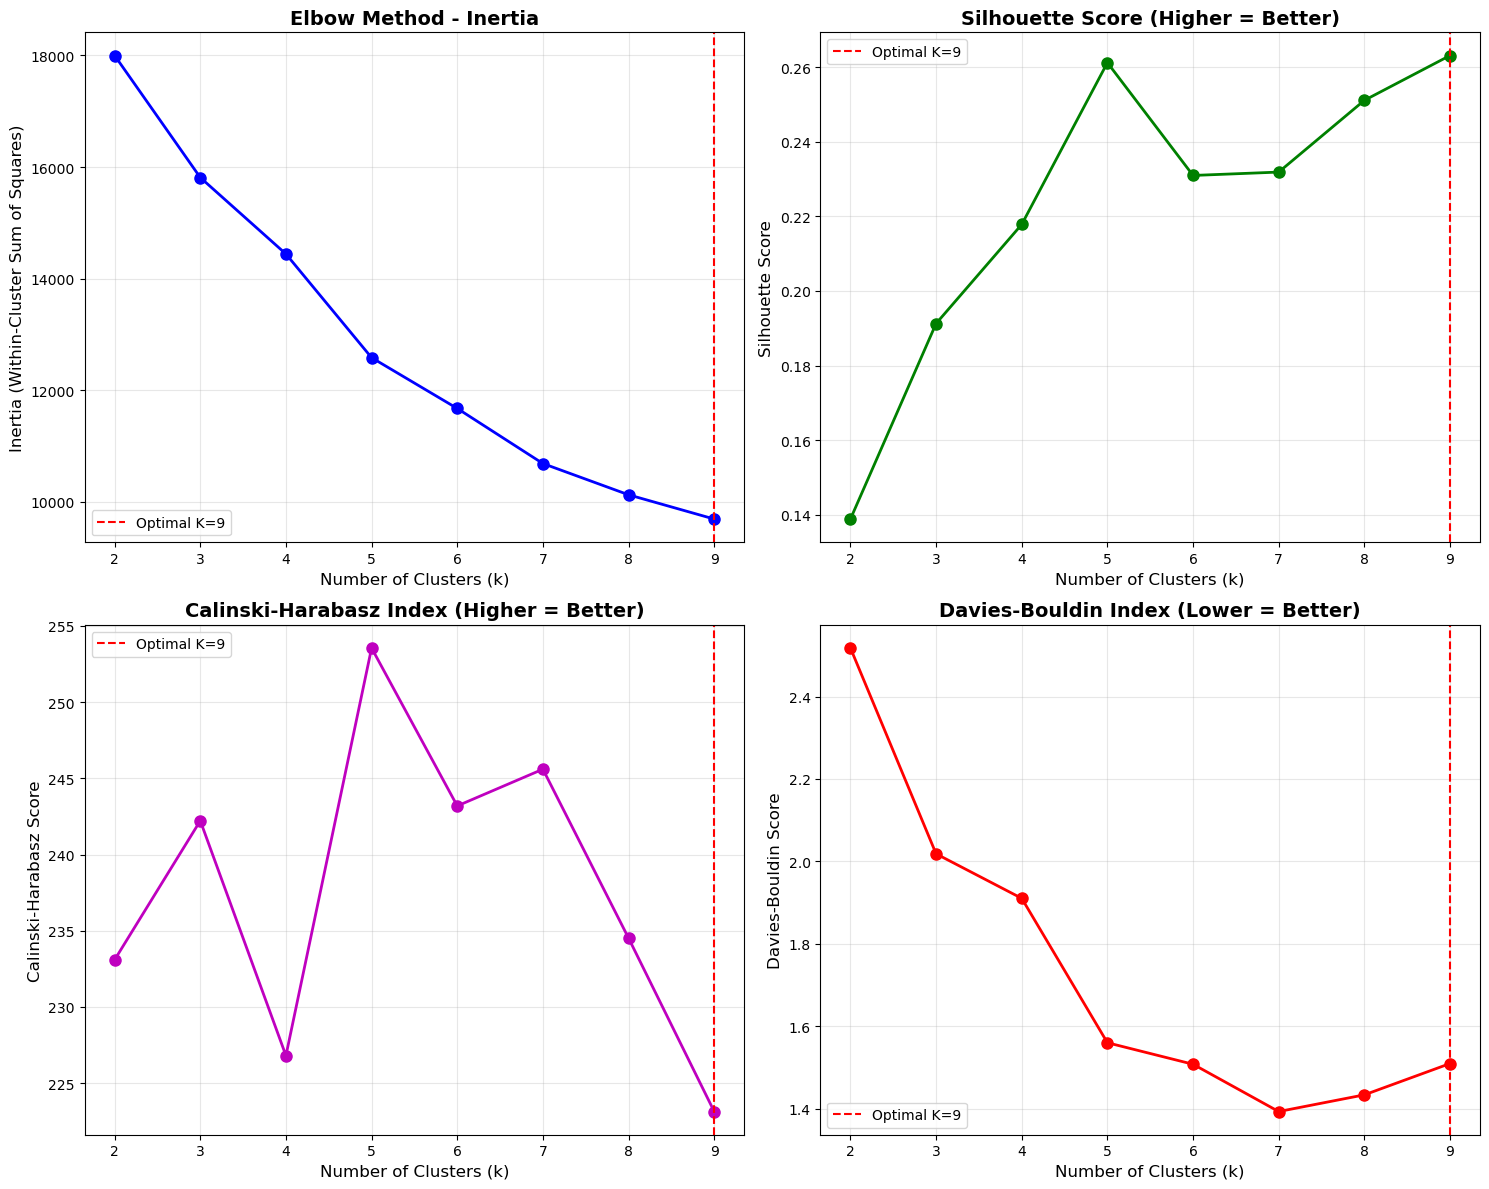

In [88]:
# ============================================================================
# 4. ELBOW METHOD - MENENTUKAN K OPTIMAL
# ============================================================================
print("[4] ELBOW METHOD - MENENTUKAN K OPTIMAL")
print("-"*80)

k_range = range(2, 10)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, "
          f"Silhouette={silhouette_scores[-1]:.4f}, "
          f"Calinski-Harabasz={calinski_scores[-1]:.2f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.4f}")

# Tentukan k optimal berdasarkan silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nK Optimal berdasarkan Silhouette Score: {optimal_k}")
print()

# Visualisasi Elbow Method
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Inertia (Elbow)
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method - Inertia', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Calinski-Harabasz Score
axes[1, 0].plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 0].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Index (Higher = Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Plot 4: Davies-Bouldin Score
axes[1, 1].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 1].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('clustering_elbow_method.png', dpi=300, bbox_inches='tight')
print("Saved: clustering_elbow_method.png")
print()

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# # # ============================================================================
# # # 6. PROFIL CLUSTER (TERPISAH PER JENIS SEKOLAH DAN GAYA BELAJAR)
# # # ============================================================================
# # print("[6] PROFIL SETIAP CLUSTER (TERPISAH PER JENIS SEKOLAH DAN GAYA BELAJAR)")
# # print("="*80)

# # for cluster_id in range(optimal_k):
# #     print(f"\nCLUSTER {cluster_id}")
# #     print("-"*80)
    
# #     cluster_data = df[df['cluster'] == cluster_id]
# #     total_cluster = len(cluster_data)
    
# #     for jenis_sekolah in ['SMA', 'SMK']:
# #         school_data = cluster_data[cluster_data['jenis_sekolah'] == jenis_sekolah]
        
# #         if len(school_data) == 0:
# #             print(f"\n{jenis_sekolah}: 0 (0.0%)")
# #             print(f"  Tidak ada data {jenis_sekolah} dalam cluster ini")
# #             continue
        
# #         count_school = len(school_data)
# #         pct_school = (count_school / total_cluster) * 100
        
# #         print(f"\n{jenis_sekolah}: {count_school} ({pct_school:.1f}%)")
# #         print()
        
# #         gaya_belajar_list = ['auditory', 'visual', 'kinestetik']
        
# #         for gaya in gaya_belajar_list:
# #             # Filter data untuk gaya belajar ini
# #             gaya_col = f'Gaya belajar yang biasanya digunakan_{gaya}'
# #             gaya_data = school_data[school_data[gaya_col] == 1]
            
# #             if len(gaya_data) == 0:
# #                 continue
                
# #             pct_gaya = (len(gaya_data) / len(school_data)) * 100
            
# #             print(f"Gaya Belajar: {gaya.title()} ({pct_gaya:.1f}%)")
# #             print()

# #             print(f"Teknik Belajar Dominan ({jenis_sekolah} - {gaya.title()}):")
# #             for feat in teknik_belajar_features:
# #                 pct = (gaya_data[feat].sum() / len(gaya_data)) * 100
# #                 feat_name = feat.replace('Teknik belajar yang biasanya digunakan_', '')
# #                 print(f"  {feat_name.replace('_', ' ').title()}: {pct:.1f}%")

# #             print(f"\nStatistik Numerik ({jenis_sekolah} - {gaya.title()}):")
# #             for feat in numerical_features:
# #                 mean_val = gaya_data[feat].mean()
# #                 print(f"  {feat}: {mean_val:.2f}")
            
# #             print()
        
# #     print("-"*80)

# print("[6] PROFIL SETIAP CLUSTER (TERPISAH PER JENIS SEKOLAH DAN GAYA BELAJAR)")
# print("="*80)

# # Looping through each cluster ID
# for cluster_id in range(optimal_k):
#     print(f"\nCLUSTER {cluster_id}")
#     print("-"*80)

#     # Filter the data for the current cluster
#     cluster_data = df[df['cluster'] == cluster_id]
    
#     # If the cluster has no data, skip processing for this cluster
#     if len(cluster_data) == 0:
#         print("  Tidak ada data untuk cluster ini")
#         continue
    
#     total_cluster = len(cluster_data)
    
#     # Pisahkan berdasarkan jenis sekolah (SMA/SMK)
#     for jenis_sekolah in ['SMA', 'SMK']:
#         school_data = cluster_data[cluster_data['jenis_sekolah'] == jenis_sekolah]
        
#         if len(school_data) == 0:
#             print(f"\n{jenis_sekolah}: 0 (0.0%)")
#             print(f"  Tidak ada data {jenis_sekolah} dalam cluster ini")
#             continue
        
#         count_school = len(school_data)
#         pct_school = (count_school / total_cluster) * 100
        
#         print(f"\n{jenis_sekolah}: {count_school} ({pct_school:.1f}%)")
#         print()
        
#         # Untuk setiap gaya belajar dalam jenis sekolah ini
#         gaya_belajar_list = ['auditory', 'visual', 'kinestetik']
        
#         for gaya in gaya_belajar_list:
#             # Filter data untuk gaya belajar ini
#             gaya_col = f'Gaya belajar yang biasanya digunakan_{gaya}'
#             gaya_data = school_data[school_data[gaya_col] == 1]
            
#             if len(gaya_data) == 0:
#                 continue
            
#             # Hitung persentase dari total sekolah
#             pct_gaya = (len(gaya_data) / len(school_data)) * 100
            
#             print(f"Gaya Belajar: {gaya.title()} ({pct_gaya:.1f}%)")
#             print()
            
#             # Teknik belajar dominan untuk gaya belajar ini
#             print(f"Teknik Belajar Dominan ({jenis_sekolah} - {gaya.title()}):")
#             for feat in teknik_belajar_features:
#                 pct = (gaya_data[feat].sum() / len(gaya_data)) * 100
#                 feat_name = feat.replace('Teknik belajar yang biasanya digunakan_', '')
#                 print(f"  {feat_name.replace('_', ' ').title()}: {pct:.1f}%")
            
#             # Statistik numerik untuk gaya belajar ini
#             print(f"\nStatistik Numerik ({jenis_sekolah} - {gaya.title()}):")
#             for feat in numerical_features:
#                 mean_val = gaya_data[feat].mean()
#                 print(f"  {feat}: {mean_val:.2f}")
            
#             print()
        
#     print("-"*80)


In [91]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming you have a DataFrame `df` and the `X_scaled` is the feature data (scaled features)
# Ensure that you have performed clustering (if not already done)

# Check if 'cluster' column exists in the dataframe
if 'cluster' not in df.columns:
    print("'cluster' column not found. Performing KMeans clustering...")
    
    # Perform KMeans clustering and assign cluster labels
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(X_scaled)  # This will add the 'cluster' column to df
    
    print(f"Clustering completed. Cluster labels assigned to 'cluster' column.")
else:
    print("'cluster' column already exists. Proceeding with analysis.")

# Proceed with your cluster analysis
print("[6] PROFIL SETIAP CLUSTER (TERPISAH PER JENIS SEKOLAH DAN GAYA BELAJAR)")
print("="*80)

# Looping through each cluster ID
for cluster_id in range(optimal_k):
    print(f"\nCLUSTER {cluster_id}")
    print("-"*80)

    # Filter the data for the current cluster
    cluster_data = df[df['cluster'] == cluster_id]
    
    # If the cluster has no data, skip processing for this cluster
    if len(cluster_data) == 0:
        print("  Tidak ada data untuk cluster ini")
        continue
    
    total_cluster = len(cluster_data)
    
    # Pisahkan berdasarkan jenis sekolah (SMA/SMK)
    for jenis_sekolah in ['SMA', 'SMK']:
        school_data = cluster_data[cluster_data['jenis_sekolah'] == jenis_sekolah]
        
        if len(school_data) == 0:
            print(f"\n{jenis_sekolah}: 0 (0.0%)")
            print(f"  Tidak ada data {jenis_sekolah} dalam cluster ini")
            continue
        
        count_school = len(school_data)
        pct_school = (count_school / total_cluster) * 100
        
        print(f"\n{jenis_sekolah}: {count_school} ({pct_school:.1f}%)")
        print()
        
        # Untuk setiap gaya belajar dalam jenis sekolah ini
        gaya_belajar_list = ['auditory', 'visual', 'kinestetik']
        
        for gaya in gaya_belajar_list:
            # Filter data untuk gaya belajar ini
            gaya_col = f'Gaya belajar yang biasanya digunakan_{gaya}'
            gaya_data = school_data[school_data[gaya_col] == 1]
            
            if len(gaya_data) == 0:
                continue
            
            # Hitung persentase dari total sekolah
            pct_gaya = (len(gaya_data) / len(school_data)) * 100
            
            print(f"Gaya Belajar: {gaya.title()} ({pct_gaya:.1f}%)")
            print()
            
            # Teknik belajar dominan untuk gaya belajar ini
            print(f"Teknik Belajar Dominan ({jenis_sekolah} - {gaya.title()}):")
            for feat in teknik_belajar_features:
                pct = (gaya_data[feat].sum() / len(gaya_data)) * 100
                feat_name = feat.replace('Teknik belajar yang biasanya digunakan_', '')
                print(f"  {feat_name.replace('_', ' ').title()}: {pct:.1f}%")
            
            # Statistik numerik untuk gaya belajar ini
            print(f"\nStatistik Numerik ({jenis_sekolah} - {gaya.title()}):")
            for feat in numerical_features:
                mean_val = gaya_data[feat].mean()
                print(f"  {feat}: {mean_val:.2f}")
            
            print()
        
    print("-"*80)


'cluster' column not found. Performing KMeans clustering...
Clustering completed. Cluster labels assigned to 'cluster' column.
[6] PROFIL SETIAP CLUSTER (TERPISAH PER JENIS SEKOLAH DAN GAYA BELAJAR)

CLUSTER 0
--------------------------------------------------------------------------------

SMA: 42 (30.2%)

Gaya Belajar: Auditory (100.0%)

Teknik Belajar Dominan (SMA - Auditory):
  Feynman: 0.0%
  Podomoro: 0.0%
  Spaced Repetition: 100.0%
  Latihan Soal: 0.0%
  Active Recall: 0.0%

Statistik Numerik (SMA - Auditory):
  Mood Saat Belajar: -0.24
  Pikiran atau Stres Akademik: -0.29
  Rata rata nilai Siswa(nilai tarakhir): 85.12
  Total Waktu untuk Belajar Mandiri /Hari: 2.57
  Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari: 3.12


SMK: 97 (69.8%)

Gaya Belajar: Auditory (100.0%)

Teknik Belajar Dominan (SMK - Auditory):
  Feynman: 0.0%
  Podomoro: 0.0%
  Spaced Repetition: 100.0%
  Latihan Soal: 0.0%
  Active Recall: 0.0%

Statistik Numerik (SMK - Auditory):
  Mood Saat Belajar:

[7] VISUALISASI CLUSTER
--------------------------------------------------------------------------------
Saved: clustering_visualization_by_school.png



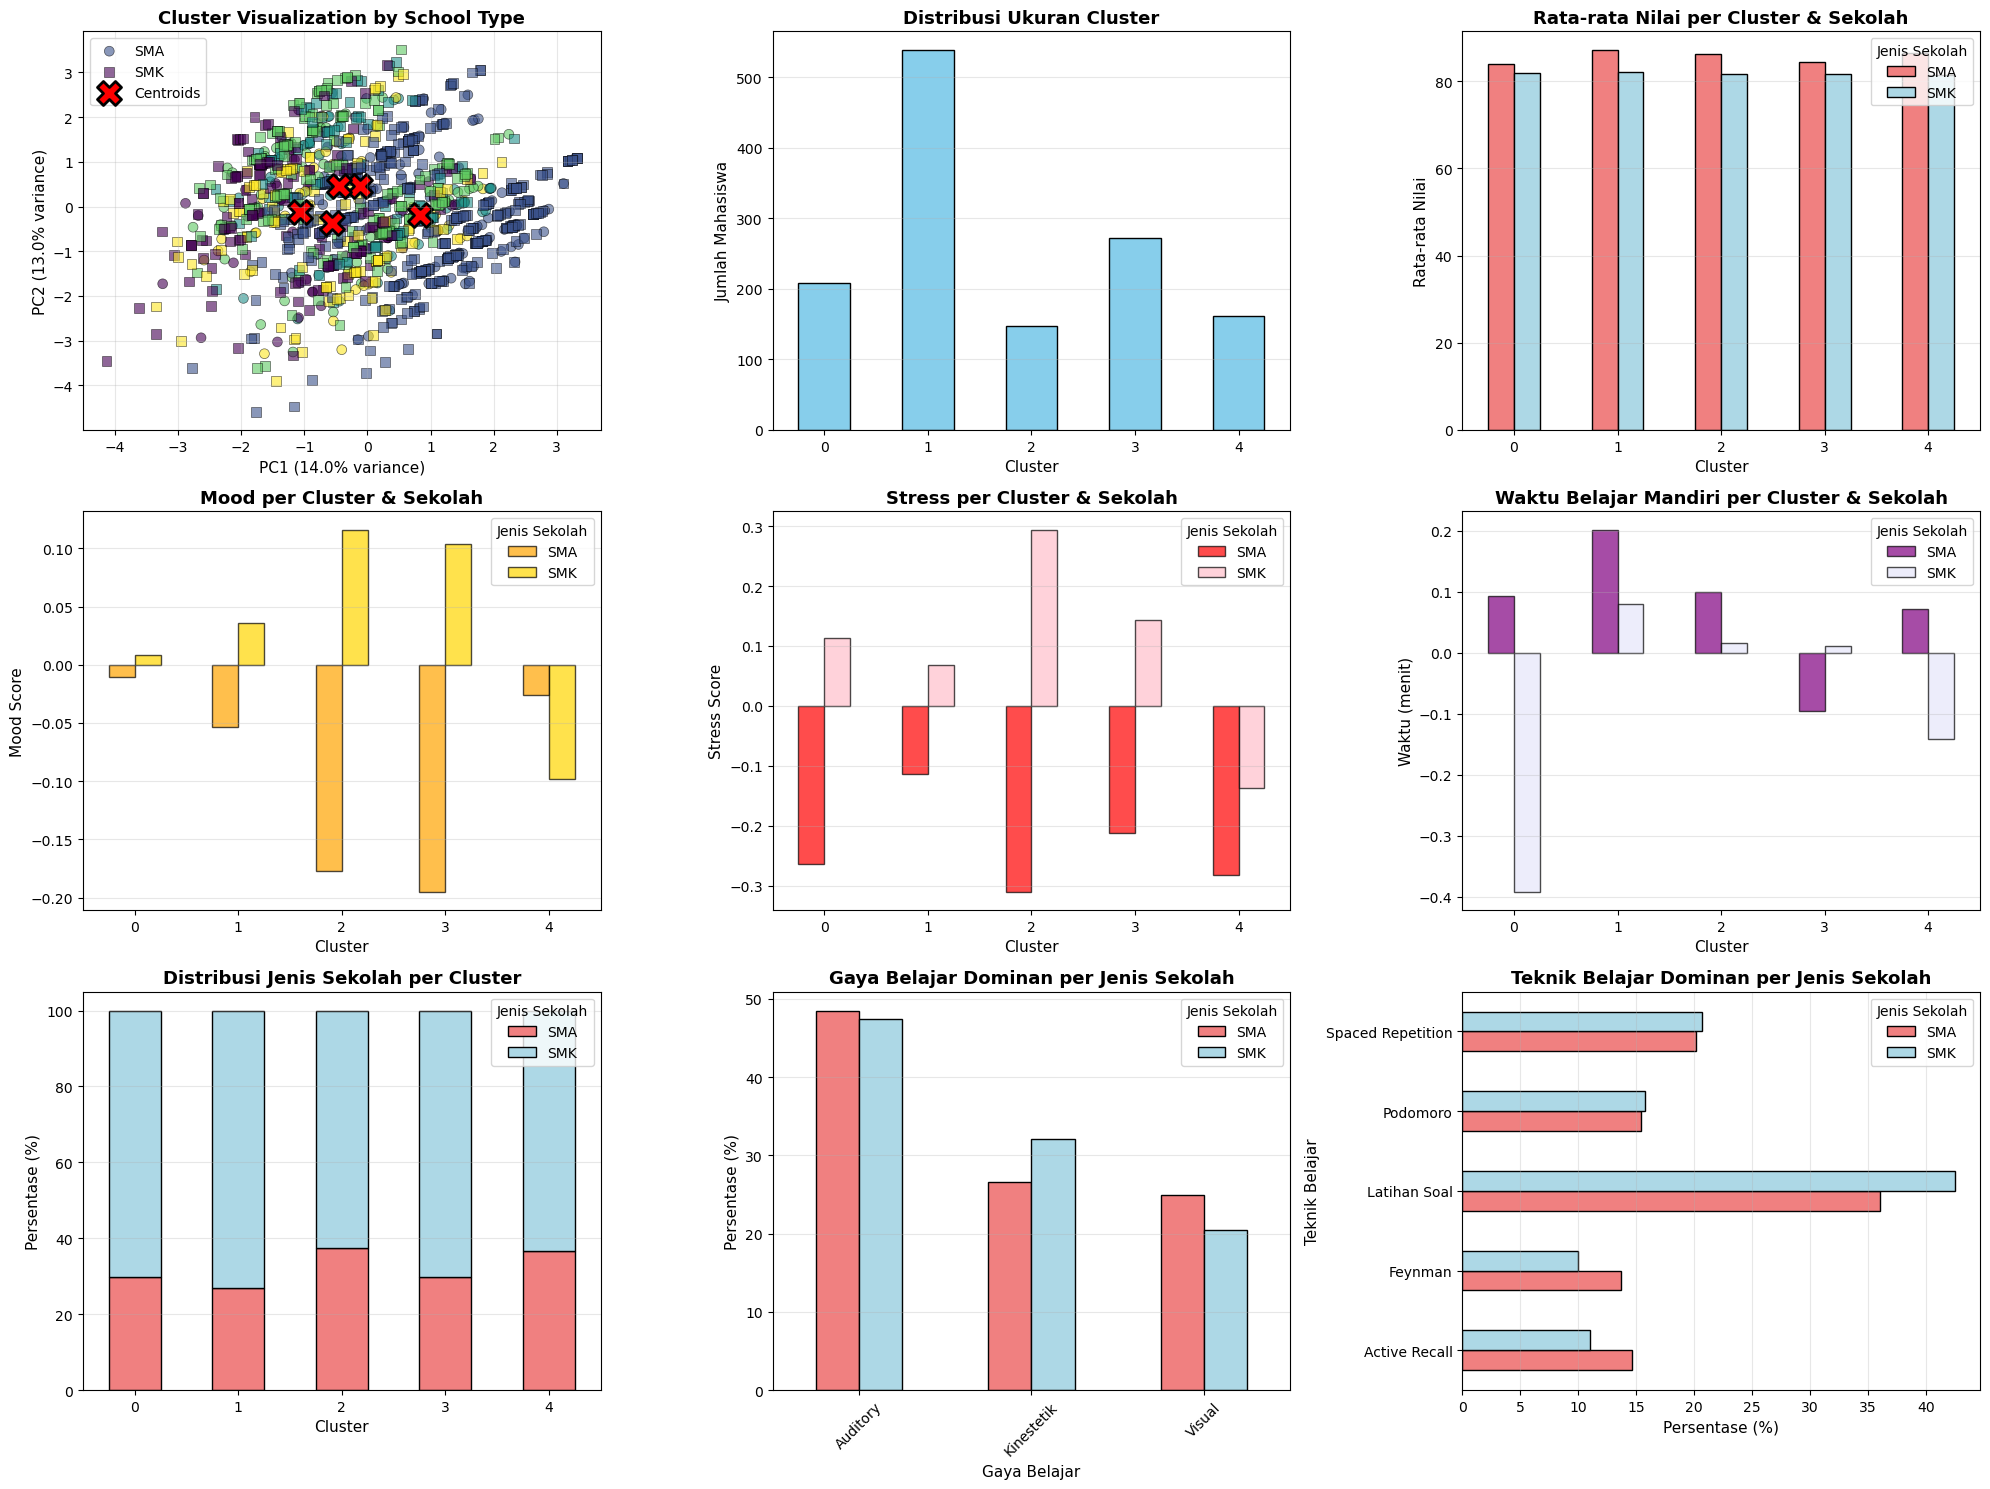

In [226]:
# ============================================================================
# 7. VISUALISASI CLUSTER
# ============================================================================
print("[7] VISUALISASI CLUSTER")
print("-"*80)

# PCA untuk visualisasi 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 15))

# Plot 1: PCA Scatter Plot with School Type
ax1 = plt.subplot(3, 3, 1)
for school in ['SMA', 'SMK']:
    mask = df['jenis_sekolah'] == school
    scatter = ax1.scatter(df[mask]['pca1'], df[mask]['pca2'], 
                          c=df[mask]['cluster'], cmap='viridis', 
                          s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
                          label=school, marker='o' if school == 'SMA' else 's')
ax1.scatter(pca.transform(kmeans_final.cluster_centers_)[:, 0],
            pca.transform(kmeans_final.cluster_centers_)[:, 1],
            c='red', marker='X', s=300, edgecolors='black', linewidth=2,
            label='Centroids')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
ax1.set_title('Cluster Visualization by School Type', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cluster Size Distribution
ax2 = plt.subplot(3, 3, 2)
cluster_counts.plot(kind='bar', ax=ax2, color='skyblue', edgecolor='black')
ax2.set_xlabel('Cluster', fontsize=11)
ax2.set_ylabel('Jumlah Mahasiswa', fontsize=11)
ax2.set_title('Distribusi Ukuran Cluster', fontsize=13, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

# Plot 3: Nilai Rata-rata per Cluster & School
ax3 = plt.subplot(3, 3, 3)
nilai_school_cluster = df.groupby(['cluster', 'jenis_sekolah'])['Rata rata nilai Siswa(nilai tarakhir)'].mean().unstack()
nilai_school_cluster.plot(kind='bar', ax=ax3, color=['lightcoral', 'lightblue'], edgecolor='black')
ax3.set_xlabel('Cluster', fontsize=11)
ax3.set_ylabel('Rata-rata Nilai', fontsize=11)
ax3.set_title('Rata-rata Nilai per Cluster & Sekolah', fontsize=13, fontweight='bold')
ax3.legend(title='Jenis Sekolah')
ax3.grid(True, axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

# Plot 4: Mood per Cluster & School
ax4 = plt.subplot(3, 3, 4)
mood_school = df.groupby(['cluster', 'jenis_sekolah'])['Mood Saat Belajar'].mean().unstack()
mood_school.plot(kind='bar', ax=ax4, color=['orange', 'gold'], alpha=0.7, edgecolor='black')
ax4.set_xlabel('Cluster', fontsize=11)
ax4.set_ylabel('Mood Score', fontsize=11)
ax4.set_title('Mood per Cluster & Sekolah', fontsize=13, fontweight='bold')
ax4.legend(title='Jenis Sekolah')
ax4.grid(True, axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

# Plot 5: Stress per Cluster & School
ax5 = plt.subplot(3, 3, 5)
stress_school = df.groupby(['cluster', 'jenis_sekolah'])['Pikiran atau Stres Akademik'].mean().unstack()
stress_school.plot(kind='bar', ax=ax5, color=['red', 'pink'], alpha=0.7, edgecolor='black')
ax5.set_xlabel('Cluster', fontsize=11)
ax5.set_ylabel('Stress Score', fontsize=11)
ax5.set_title('Stress per Cluster & Sekolah', fontsize=13, fontweight='bold')
ax5.legend(title='Jenis Sekolah')
ax5.grid(True, axis='y', alpha=0.3)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=0)

# Plot 6: Waktu Belajar Mandiri per Cluster & School
ax6 = plt.subplot(3, 3, 6)
waktu_mandiri = df.groupby(['cluster', 'jenis_sekolah'])['Total Waktu untuk Belajar Mandiri /Hari'].mean().unstack()
waktu_mandiri.plot(kind='bar', ax=ax6, color=['purple', 'lavender'], alpha=0.7, edgecolor='black')
ax6.set_xlabel('Cluster', fontsize=11)
ax6.set_ylabel('Waktu (menit)', fontsize=11)
ax6.set_title('Waktu Belajar Mandiri per Cluster & Sekolah', fontsize=13, fontweight='bold')
ax6.legend(title='Jenis Sekolah')
ax6.grid(True, axis='y', alpha=0.3)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=0)

# Plot 7: Distribusi Jenis Sekolah per Cluster
ax7 = plt.subplot(3, 3, 7)
school_cluster = pd.crosstab(df['cluster'], df['jenis_sekolah'], normalize='index') * 100
school_cluster.plot(kind='bar', stacked=True, ax=ax7, color=['lightcoral', 'lightblue'], edgecolor='black')
ax7.set_xlabel('Cluster', fontsize=11)
ax7.set_ylabel('Persentase (%)', fontsize=11)
ax7.set_title('Distribusi Jenis Sekolah per Cluster', fontsize=13, fontweight='bold')
ax7.legend(title='Jenis Sekolah', loc='best')
ax7.grid(True, axis='y', alpha=0.3)
plt.setp(ax7.xaxis.get_majorticklabels(), rotation=0)

# Plot 8: Gaya Belajar Dominan per School Type
ax8 = plt.subplot(3, 3, 8)
gaya_data = []
for school in ['SMA', 'SMK']:
    school_df = df[df['jenis_sekolah'] == school]
    for feat in gaya_belajar_features:
        feat_name = feat.replace('Gaya belajar yang biasanya digunakan_', '').title()
        pct = (school_df[feat].sum() / len(school_df)) * 100
        gaya_data.append({'Sekolah': school, 'Gaya': feat_name, 'Persentase': pct})
gaya_df = pd.DataFrame(gaya_data)
gaya_pivot = gaya_df.pivot(index='Gaya', columns='Sekolah', values='Persentase')
gaya_pivot.plot(kind='bar', ax=ax8, color=['lightcoral', 'lightblue'], edgecolor='black')
ax8.set_xlabel('Gaya Belajar', fontsize=11)
ax8.set_ylabel('Persentase (%)', fontsize=11)
ax8.set_title('Gaya Belajar Dominan per Jenis Sekolah', fontsize=13, fontweight='bold')
ax8.legend(title='Jenis Sekolah')
ax8.grid(True, axis='y', alpha=0.3)
plt.setp(ax8.xaxis.get_majorticklabels(), rotation=45)

# Plot 9: Teknik Belajar Dominan per School Type
ax9 = plt.subplot(3, 3, 9)
teknik_data = []
for school in ['SMA', 'SMK']:
    school_df = df[df['jenis_sekolah'] == school]
    for feat in teknik_belajar_features:
        feat_name = feat.replace('Teknik belajar yang biasanya digunakan_', '').replace('_', ' ').title()
        pct = (school_df[feat].sum() / len(school_df)) * 100
        if pct > 5:  # Only show techniques used by >5%
            teknik_data.append({'Sekolah': school, 'Teknik': feat_name, 'Persentase': pct})
teknik_df = pd.DataFrame(teknik_data)
if len(teknik_df) > 0:
    teknik_pivot = teknik_df.pivot(index='Teknik', columns='Sekolah', values='Persentase')
    teknik_pivot.plot(kind='barh', ax=ax9, color=['lightcoral', 'lightblue'], edgecolor='black')
    ax9.set_xlabel('Persentase (%)', fontsize=11)
    ax9.set_ylabel('Teknik Belajar', fontsize=11)
    ax9.set_title('Teknik Belajar Dominan per Jenis Sekolah', fontsize=13, fontweight='bold')
    ax9.legend(title='Jenis Sekolah')
    ax9.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_visualization_by_school.png', dpi=300, bbox_inches='tight')
print("Saved: clustering_visualization_by_school.png")
print()


In [92]:
# ============================================================================
# 8. REKOMENDASI PER CLUSTER, JENIS SEKOLAH & GAYA BELAJAR
# ============================================================================
print("[8] REKOMENDASI PER CLUSTER, JENIS SEKOLAH & GAYA BELAJAR")
print("="*80)

for cluster_id in range(optimal_k):
    print(f"\nREKOMENDASI CLUSTER {cluster_id}")
    print("-"*80)
    
    cluster_data = df[df['cluster'] == cluster_id]
    
    for jenis_sekolah in ['SMA', 'SMK']:
        school_data = cluster_data[cluster_data['jenis_sekolah'] == jenis_sekolah]
        
        if len(school_data) == 0:
            continue
        
        print(f"\n{jenis_sekolah}:")
        print()
        
        # Untuk setiap gaya belajar
        gaya_belajar_list = ['auditory', 'visual', 'kinestetik']
        
        for gaya in gaya_belajar_list:
            gaya_col = f'Gaya belajar yang biasanya digunakan_{gaya}'
            gaya_data = school_data[school_data[gaya_col] == 1]
            
            if len(gaya_data) == 0:
                continue
            
            print(f"  Gaya Belajar: {gaya.title()}")
            
            avg_nilai = gaya_data['Rata rata nilai Siswa(nilai tarakhir)'].mean()
            avg_mood = gaya_data['Mood Saat Belajar'].mean()
            avg_stress = gaya_data['Pikiran atau Stres Akademik'].mean()
            avg_waktu = gaya_data['Total Waktu untuk Belajar Mandiri /Hari'].mean()
            avg_pr = gaya_data['Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari'].mean()
            
            # Analisis teknik belajar dominan untuk gaya ini
            teknik_scores = {}
            for feat in teknik_belajar_features:
                teknik_name = feat.replace('Teknik belajar yang biasanya digunakan_', '')
                teknik_scores[teknik_name] = (gaya_data[feat].sum() / len(gaya_data)) * 100
            teknik_dominan = max(teknik_scores, key=teknik_scores.get)
            
            print(f"    Profil: Nilai rata-rata {avg_nilai:.1f}, Mood {avg_mood:.2f}, Stress {avg_stress:.2f}")
            print(f"    Pola: {gaya.title()} + {teknik_dominan.replace('_', ' ').title()}")
            print(f"    Waktu: Belajar Mandiri {avg_waktu:.2f} jam/hari, PR {avg_pr:.2f} jam/hari")
            
            # Rekomendasi berdasarkan performa
            if avg_nilai >= 85:
                print(f"    Rekomendasi: Excellent! Pertahankan strategi {gaya.title()} + {teknik_dominan.replace('_', ' ').title()}")
            elif avg_nilai >= 75:
                print(f"    Rekomendasi: Bagus! Tingkatkan konsistensi dan coba teknik belajar tambahan")
            elif avg_nilai >= 65:
                print(f"    Rekomendasi: Tingkatkan durasi belajar +30 menit/hari, kelola stress lebih baik")
            else:
                print(f"    Rekomendasi: Perlu perbaikan! Coba kombinasi gaya belajar dan konsultasi guru")
            
            # Rekomendasi khusus berdasarkan mood dan stress
            if avg_mood < 0:
                print(f"    Perhatian: Mood rendah terdeteksi. Cari lingkungan belajar yang lebih nyaman")
            if avg_stress > 0.5:
                print(f"    Perhatian: Stress tinggi terdeteksi. Lakukan teknik relaksasi dan time management")
            
            print()
    
    print()


# Simpan hasil clustering dengan breakdown gaya belajar
df_hasil_detail = []

for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    for school in ['SMA', 'SMK']:
        school_data = cluster_data[cluster_data['jenis_sekolah'] == school]
        if len(school_data) > 0:
            for gaya in ['auditory', 'visual', 'kinestetik']:
                gaya_col = f'Gaya belajar yang biasanya digunakan_{gaya}'
                gaya_data = school_data[school_data[gaya_col] == 1]
                
                if len(gaya_data) > 0:
                    # Hitung teknik belajar dominan
                    teknik_pct = {}
                    for feat in teknik_belajar_features:
                        teknik_name = feat.replace('Teknik belajar yang biasanya digunakan_', '')
                        teknik_pct[teknik_name] = (gaya_data[feat].sum() / len(gaya_data)) * 100
                    teknik_dominan = max(teknik_pct, key=teknik_pct.get)
                    
                    df_hasil_detail.append({
                        'Cluster': cluster_id,
                        'Jenis_Sekolah': school,
                        'Gaya_Belajar': gaya.title(),
                        'Jumlah': len(gaya_data),
                        'Persen_dari_Sekolah': (len(gaya_data) / len(school_data)) * 100,
                        'Teknik_Dominan': teknik_dominan,
                        'Nilai_Rata': gaya_data['Rata rata nilai Siswa(nilai tarakhir)'].mean(),
                        'Mood_Rata': gaya_data['Mood Saat Belajar'].mean(),
                        'Stress_Rata': gaya_data['Pikiran atau Stres Akademik'].mean(),
                        'Waktu_Belajar': gaya_data['Total Waktu untuk Belajar Mandiri /Hari'].mean(),
                        'Waktu_PR': gaya_data['Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari'].mean()
                    })

hasil_detail_df = pd.DataFrame(df_hasil_detail)
hasil_detail_df.to_csv('clustering_detail_by_school_and_style.csv', index=False)
print("Saved: clustering_detail_by_school_and_style.csv")

[8] REKOMENDASI PER CLUSTER, JENIS SEKOLAH & GAYA BELAJAR

REKOMENDASI CLUSTER 0
--------------------------------------------------------------------------------

SMA:

  Gaya Belajar: Auditory
    Profil: Nilai rata-rata 85.1, Mood -0.24, Stress -0.29
    Pola: Auditory + Spaced Repetition
    Waktu: Belajar Mandiri 2.57 jam/hari, PR 3.12 jam/hari
    Rekomendasi: Excellent! Pertahankan strategi Auditory + Spaced Repetition
    Perhatian: Mood rendah terdeteksi. Cari lingkungan belajar yang lebih nyaman


SMK:

  Gaya Belajar: Auditory
    Profil: Nilai rata-rata 83.6, Mood 0.21, Stress 0.18
    Pola: Auditory + Spaced Repetition
    Waktu: Belajar Mandiri 2.58 jam/hari, PR 2.66 jam/hari
    Rekomendasi: Bagus! Tingkatkan konsistensi dan coba teknik belajar tambahan



REKOMENDASI CLUSTER 1
--------------------------------------------------------------------------------

SMA:

  Gaya Belajar: Kinestetik
    Profil: Nilai rata-rata 85.3, Mood -0.07, Stress -0.22
    Pola: Kinestetik + 

In [228]:
# ============================================================================
# 9. SIMPAN MODEL DAN HASIL
# ============================================================================
print("[9] MENYIMPAN MODEL DAN HASIL")
print("-"*80)

joblib.dump(kmeans_final, 'model_kmeans_clustering.pkl')
print("Saved: model_kmeans_clustering.pkl")

joblib.dump(scaler, 'scaler_clustering.pkl')
print("Saved: scaler_clustering.pkl")

joblib.dump(pca, 'pca_clustering.pkl')
print("Saved: pca_clustering.pkl")

df_hasil = df[['cluster', 'jenis_sekolah', 'Rata rata nilai Siswa(nilai tarakhir)',
               'Mood Saat Belajar', 'Pikiran atau Stres Akademik',
               'Total Waktu untuk Belajar Mandiri /Hari',
               'Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari'] + 
              gaya_belajar_features + teknik_belajar_features]
df_hasil.to_csv('clustering_results_by_school.csv', index=False)
print("Saved: clustering_results_by_school.csv")

# Simpan summary profil
summary_data = []
for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    for school in ['SMA', 'SMK']:
        school_data = cluster_data[cluster_data['jenis_sekolah'] == school]
        if len(school_data) > 0:
            summary_data.append({
                'Cluster': cluster_id,
                'Jenis_Sekolah': school,
                'Jumlah': len(school_data),
                'Nilai_Rata': school_data['Rata rata nilai Siswa(nilai tarakhir)'].mean(),
                'Mood_Rata': school_data['Mood Saat Belajar'].mean(),
                'Stress_Rata': school_data['Pikiran atau Stres Akademik'].mean(),
                'Waktu_Belajar': school_data['Total Waktu untuk Belajar Mandiri /Hari'].mean()
            })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('clustering_summary_by_school.csv', index=False)
print("Saved: clustering_summary_by_school.csv")

print()
print("="*80)
print("CLUSTERING ANALYSIS SELESAI")
print("="*80)

[9] MENYIMPAN MODEL DAN HASIL
--------------------------------------------------------------------------------
Saved: model_kmeans_clustering.pkl
Saved: scaler_clustering.pkl
Saved: pca_clustering.pkl
Saved: clustering_results_by_school.csv
Saved: clustering_summary_by_school.csv

CLUSTERING ANALYSIS SELESAI
